In [1]:
import os
import numpy as np
import pandas as pd
import sys
import glob
import h5py
import pickle
import scipy
import time
import copy
import bilby
from gwpy.timeseries import TimeSeries
from scipy.signal.windows import tukey
from itertools import product
import lalsimulation as lalsim
import lal
#import tbs

from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters
from bilby.gw.prior import BBHPriorDict
from bilby.gw.source import lal_binary_black_hole
from bilby.gw.detector import PowerSpectralDensity
from tqdm.auto import trange
from scipy.special import logsumexp

import matplotlib.pyplot as plt
%matplotlib inline

def timeSeries_from_h5 (filename, 
                        channel = 'H1:GDS-CALIB_STRAIN' ):

    """
    To read the .h5 output files produced by dc-prod-clean
    this format is used for storing the original (unclean) data
    NB: Cleaned data are stored as frame files

    Parameters
    ----------
    filename : `str`
        path to the h5 file to be read
    channel  : `str`
        default is 'H1:GDS-CALIB_STRAIN'
    
    Returns:
    --------
    data_ts : `gwpy.timeseries.TimeSeries`
        the data in the timeseries format.

    """

    f = h5py.File(filename, 'r')
    channels = list(f.keys())

    self_channels = []
    self_data = []
    with h5py.File(filename, 'r') as f:
        fobj = f
        for chan, data in fobj.items():
            if chan not in channels:
                continue
            self_channels.append(chan)
            self_data.append(data[:])
            t0 = data.attrs['t0']
            fs = data.attrs['sample_rate']

    data_ndarray = self_data[self_channels.index(channel)]
    data_ts = TimeSeries(data_ndarray, t0=t0, sample_rate=fs, name=channel, unit="ct", channel=channel)
    
    return data_ts

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
datadir = "/home/weizmann.kiendrebeogo/DeepClean/DeepClean_CIT/Friday_Work/15_415_Hz/data"
inj_file             = os.path.join(datadir, 'INJ-1265127585-4096.csv')
injections = pd.read_csv(inj_file)
injection_times = injections['geocent_time'].to_list()
duration = 8
post_trigger_duration = 2
sampling_frequency = 4096
minimum_frequency = 15
maximum_frequency = 1024
reference_frequency = 20
prior_file = "./prior.prior"
inject = False
waveform_approximant="IMRPhenomPv2"
priors = bilby.gw.prior.BBHPriorDict(prior_file)
deltaT = 0.5

In [3]:
# we will have only 128 pids for one frame file of 4096 seconds and injections spaced by 32 seconds
pid = 30
trigtime = injection_times[pid]
end_time = trigtime +  post_trigger_duration
start_time = end_time - duration
# priors['geocent_time'] = bilby.gw.prior.DeltaFunction(
#     peak=trigtime, name=None, latex_label=None, unit=None)
priors['geocent_time'] = bilby.gw.prior.Uniform(minimum=trigtime-deltaT, 
        maximum=trigtime+deltaT, name='geocent_time')

In [4]:
waveform_arguments=dict(minimum_frequency=minimum_frequency, 
                        maximum_frequency = maximum_frequency)
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    start_time=start_time,
    frequency_domain_source_model=lal_binary_black_hole,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments
)




15:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [5]:
result_file = f"outdir_dc/virgo_deepclean_pe_injection_{pid}_result.json"
results = bilby.result.read_in_result(result_file)

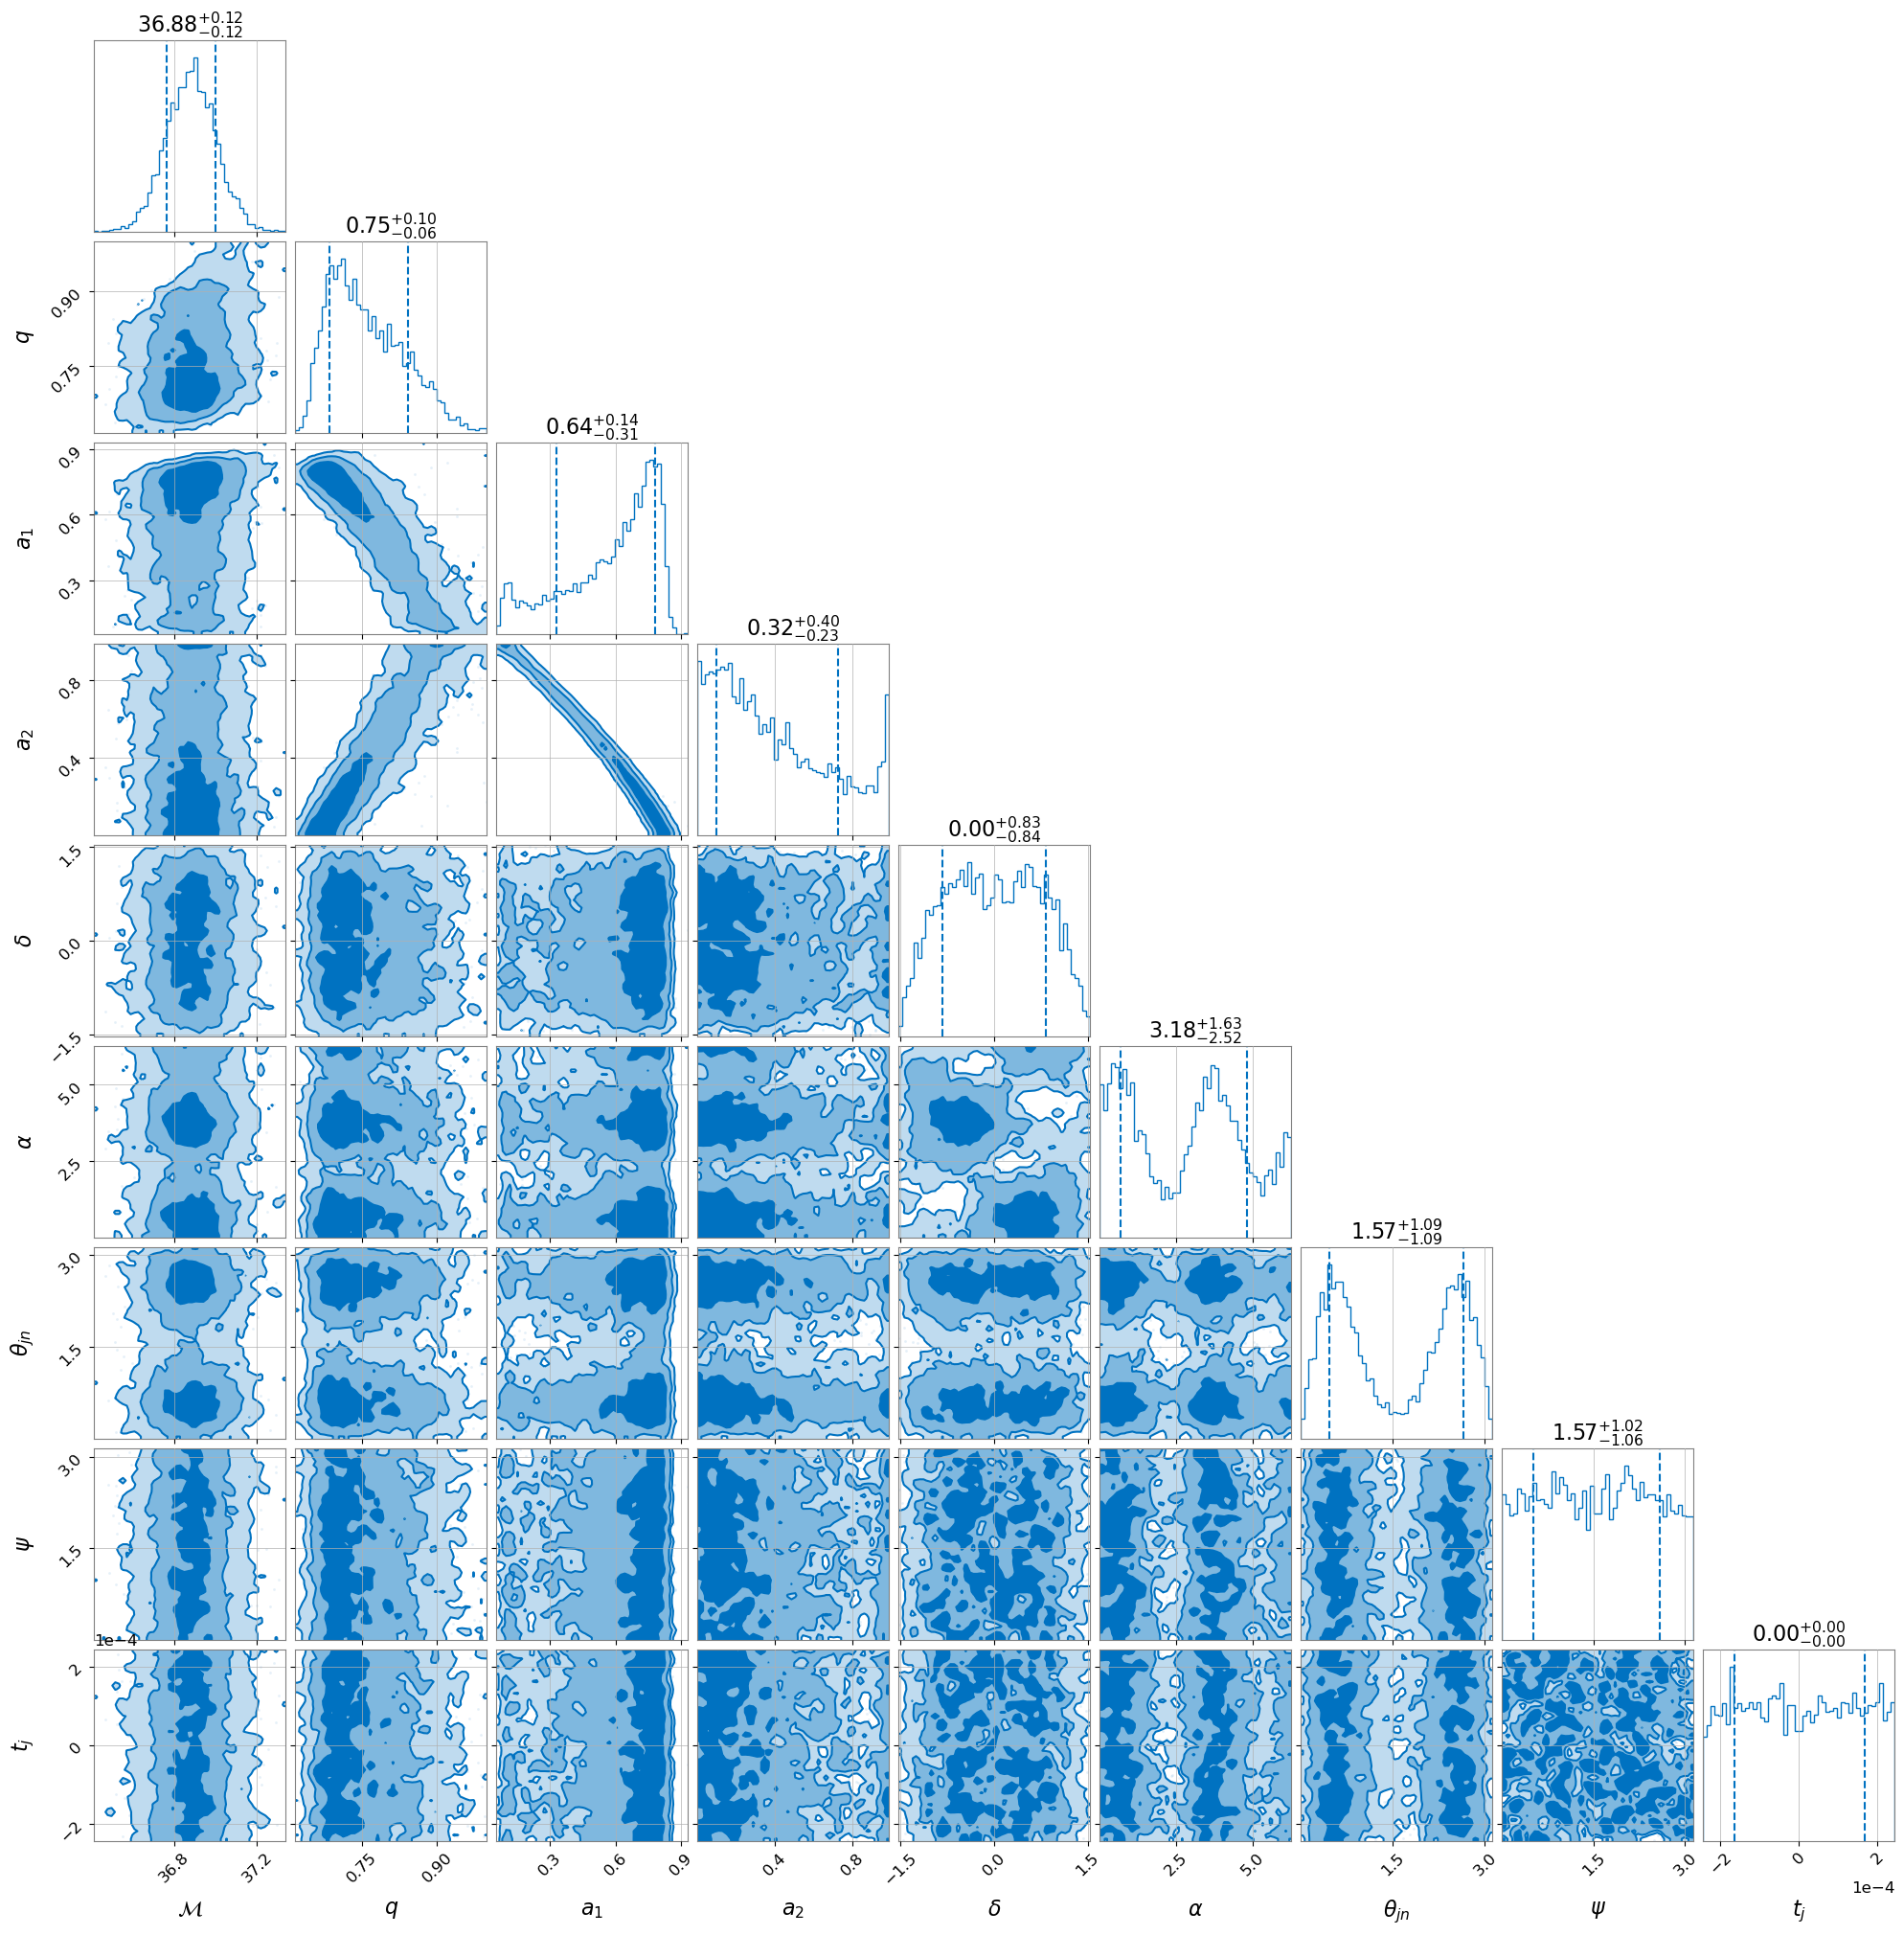

In [6]:
results.plot_corner()

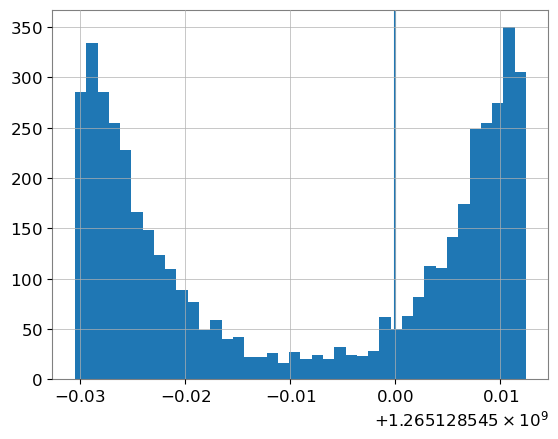

In [7]:
plt.hist(results.posterior['geocent_time'], 40)
plt.axvline(injection_times[pid])

In [8]:
Mc_inj  = bilby.gw.conversion.component_masses_to_chirp_mass(injections['mass_1'], injections['mass_2'])
q_inj  = bilby.gw.conversion.component_masses_to_mass_ratio(injections['mass_1'], injections['mass_2'])

Text(0.5, 0, 'Mass ratio')

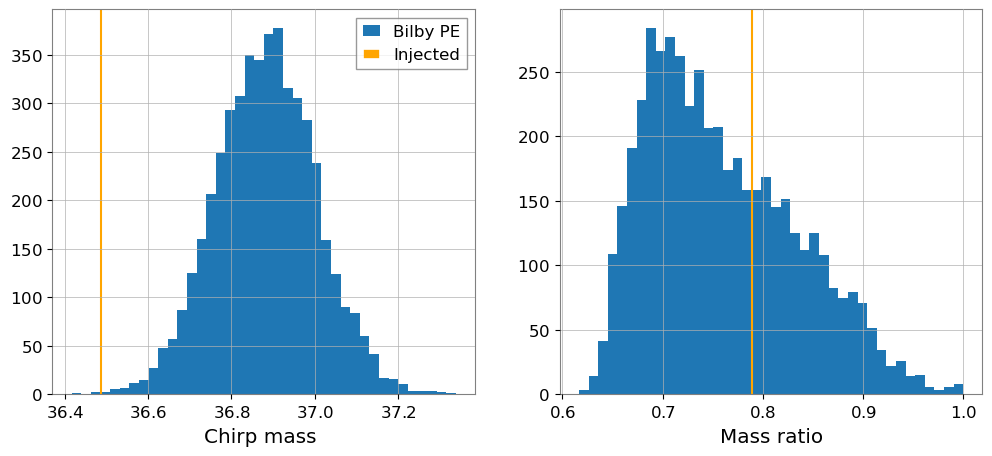

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(results.posterior['chirp_mass'], 40, label="Bilby PE")
plt.axvline(Mc_inj[pid], color = 'orange',  label = 'Injected')
plt.xlabel("Chirp mass ")
plt.legend()

plt.subplot(122)
plt.hist(results.posterior['mass_ratio'], 40, label="Bilby PE")
plt.axvline(q_inj[pid], color = 'orange', label = 'Injected')
plt.xlabel("Mass ratio")

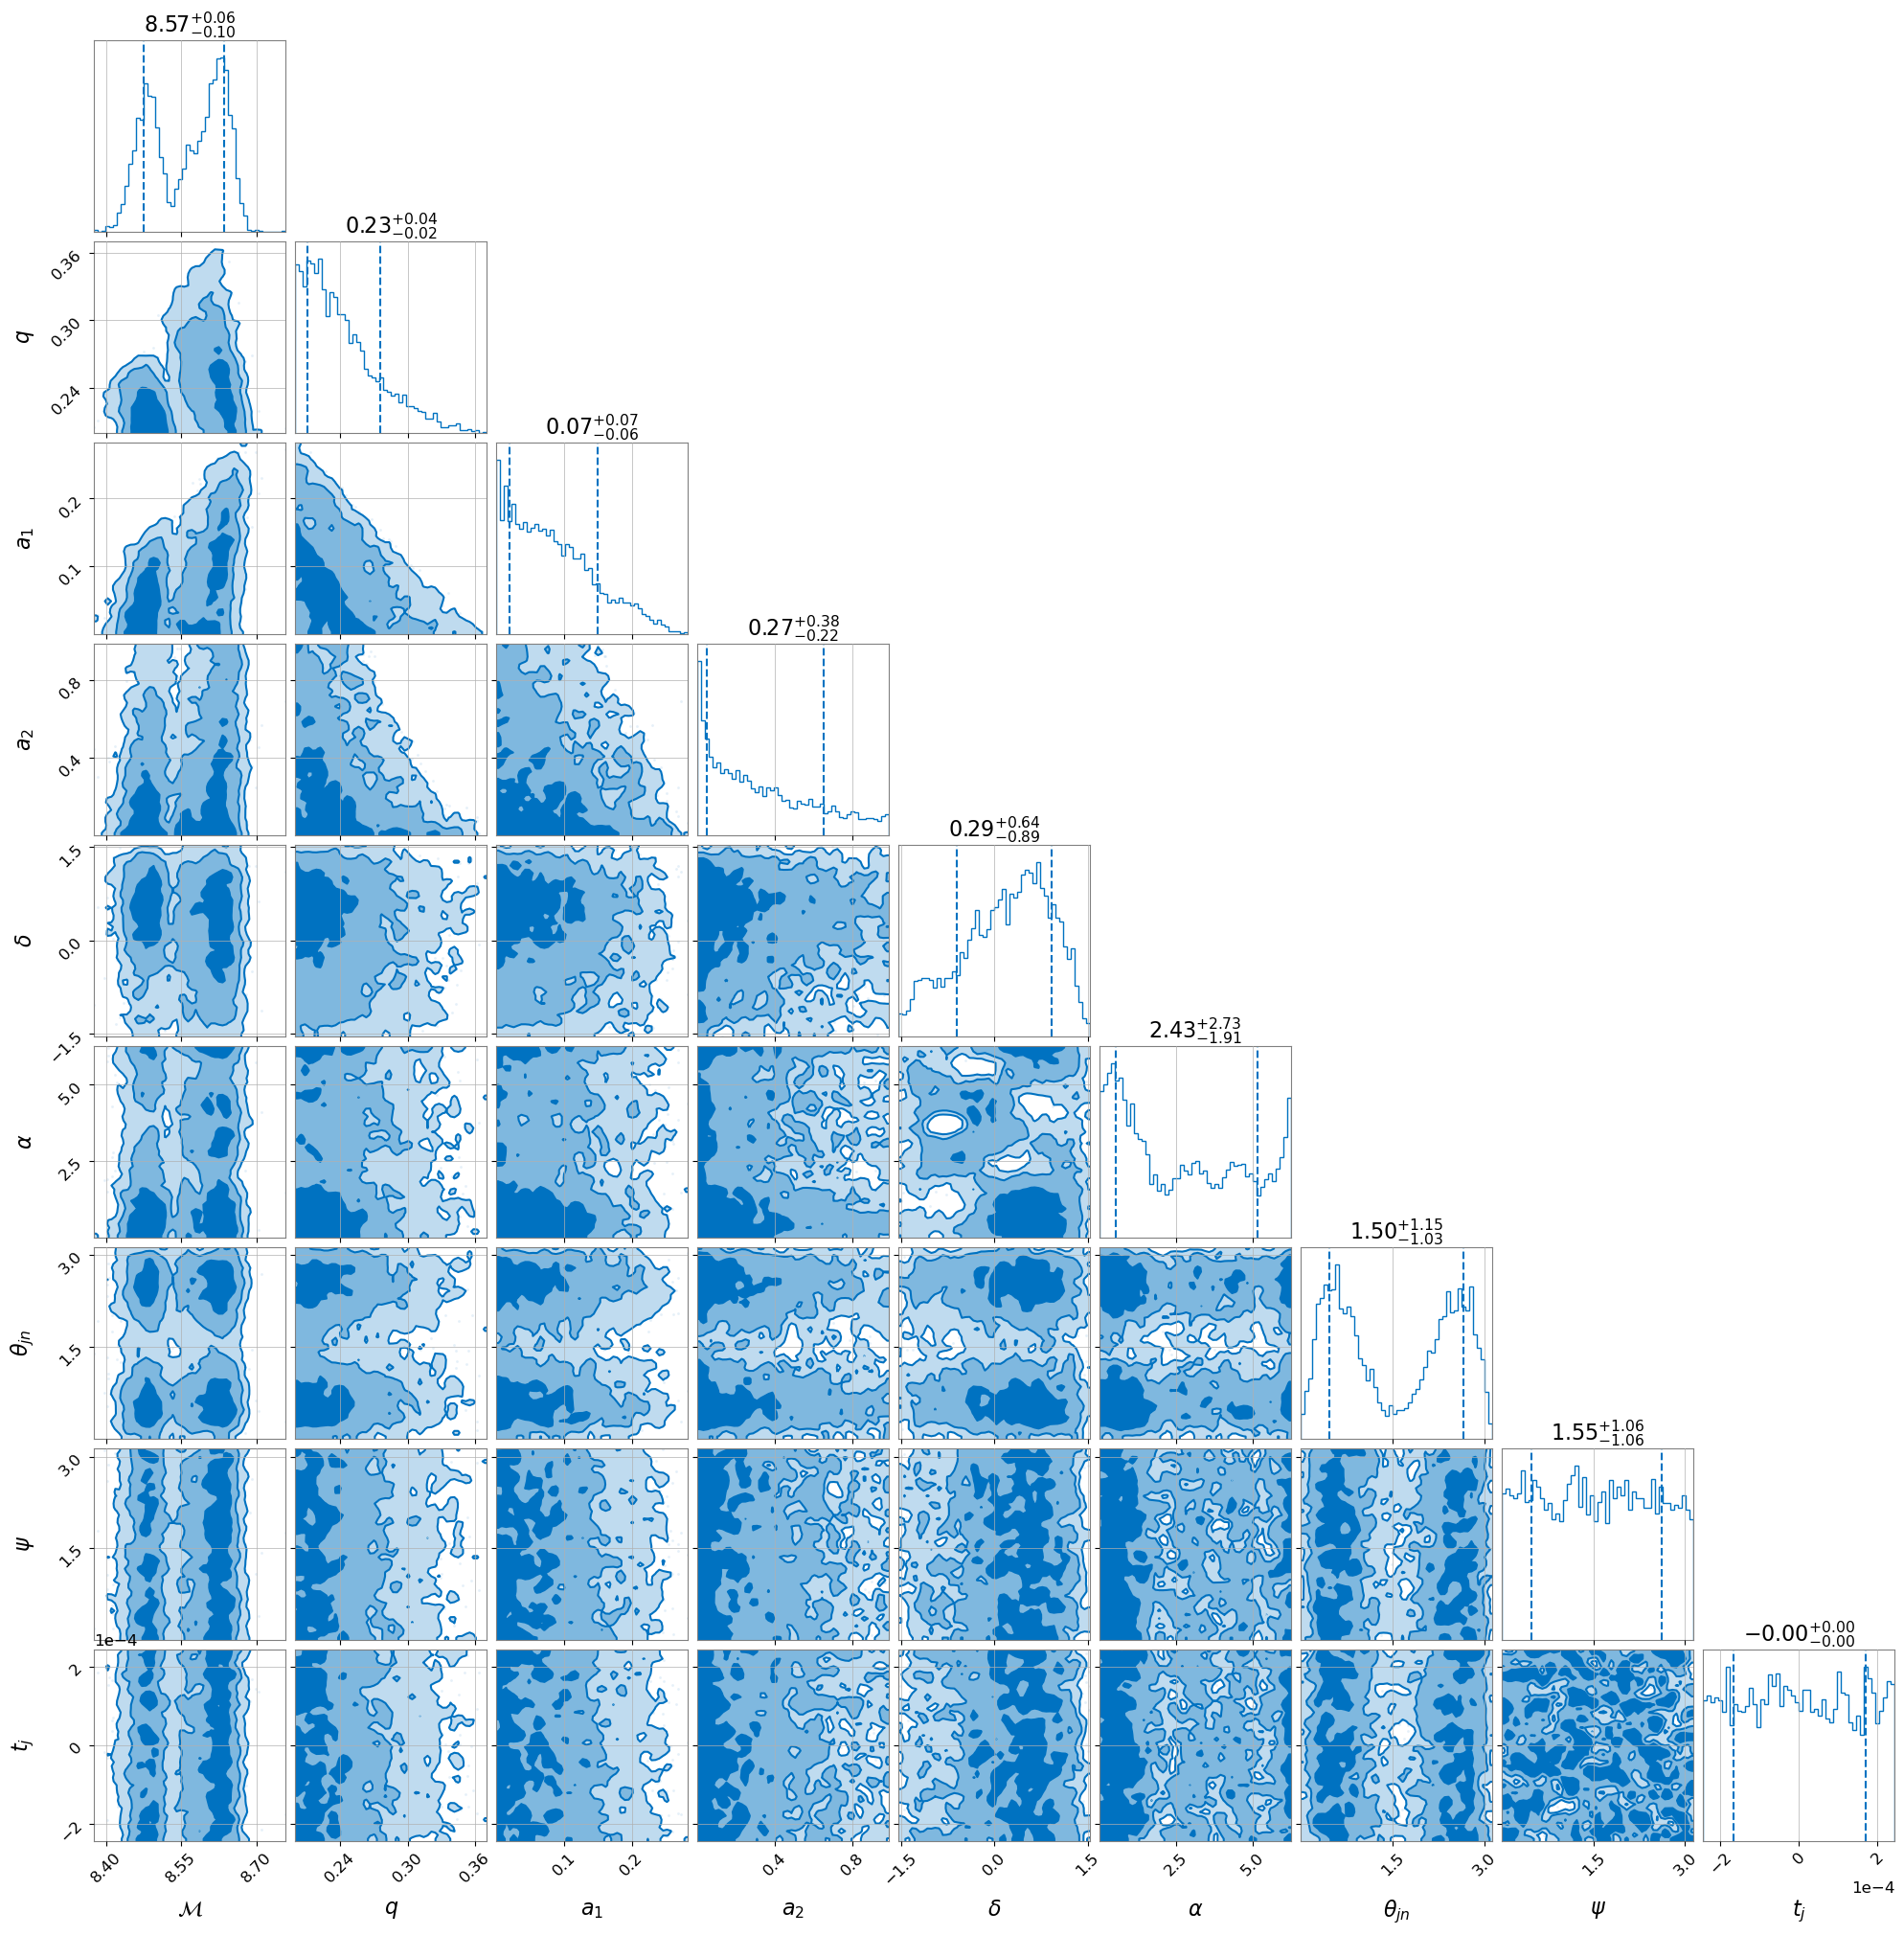

In [10]:
# we will have only 128 pids for one frame file of 4096 seconds and injections spaced by 32 seconds
pid = 0
trigtime = injection_times[pid]
result_file = f"outdir_dc/virgo_deepclean_pe_injection_{pid}_result.json"
results = bilby.result.read_in_result(result_file)
results.plot_corner()


Text(0.5, 0, 'Mass ratio')

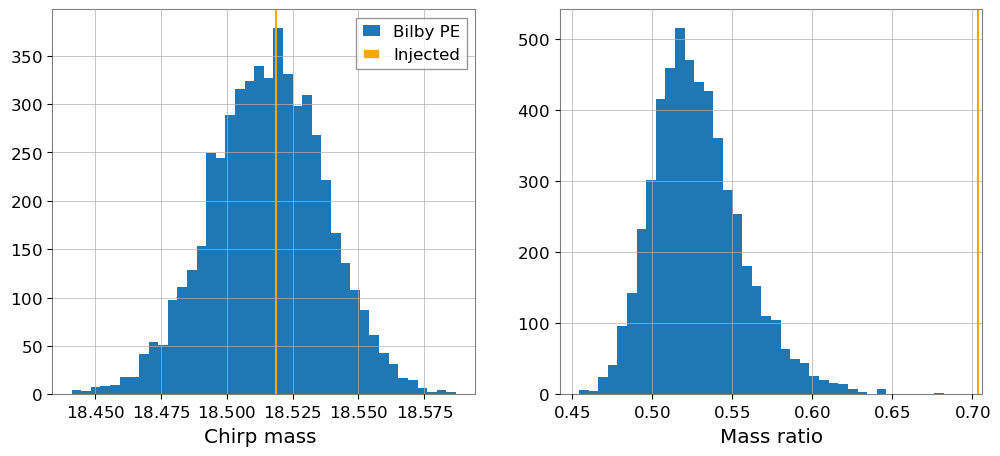

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(results.posterior['chirp_mass'], 40, label="Bilby PE")
plt.axvline(Mc_inj[pid], color = 'orange',  label = 'Injected')
plt.xlabel("Chirp mass ")
plt.legend()

plt.subplot(122)
plt.hist(results.posterior['mass_ratio'], 40, label="Bilby PE")
plt.axvline(q_inj[pid], color = 'orange', label = 'Injected')
plt.xlabel("Mass ratio")

Results not available: 6
Results not available: 8


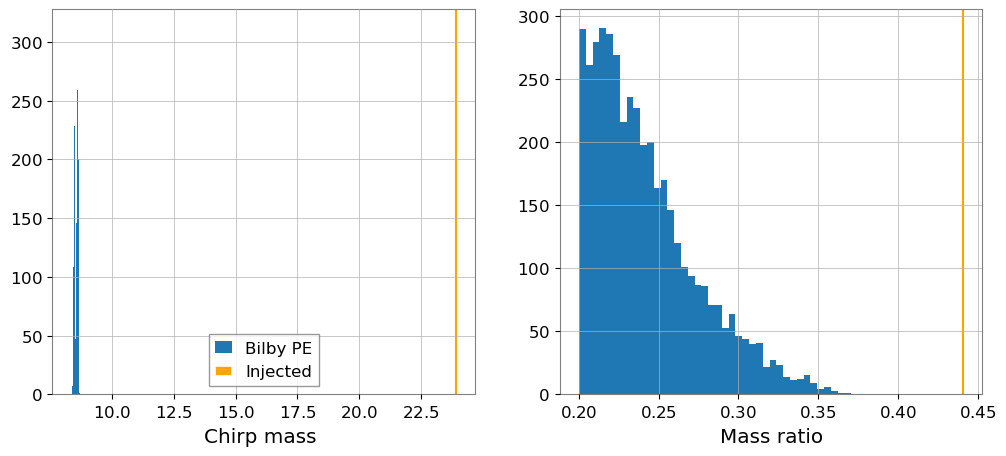

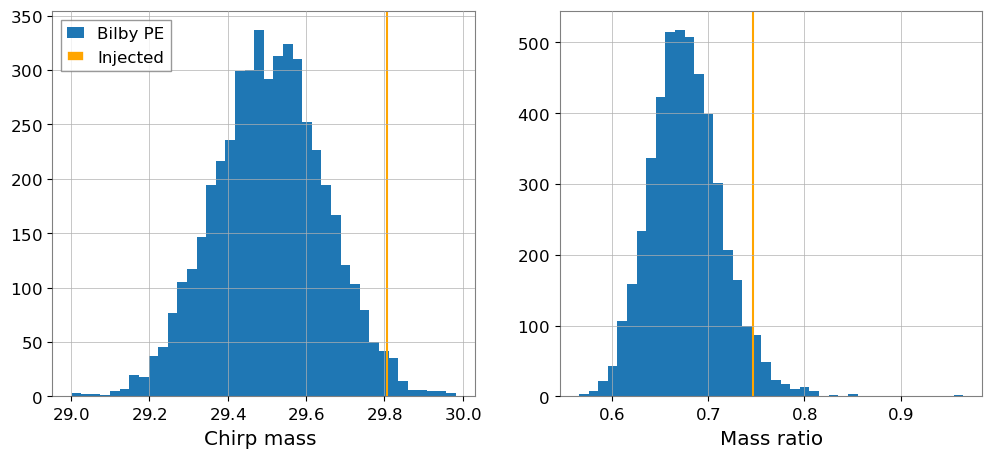

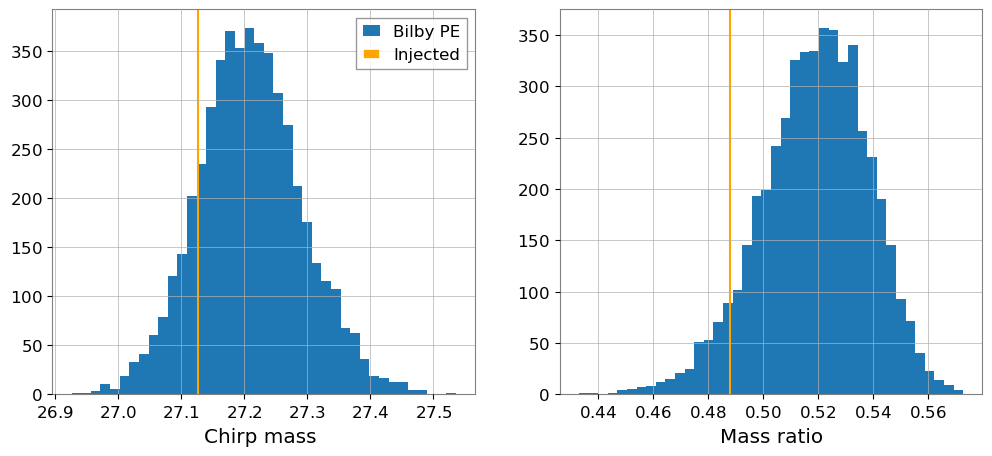

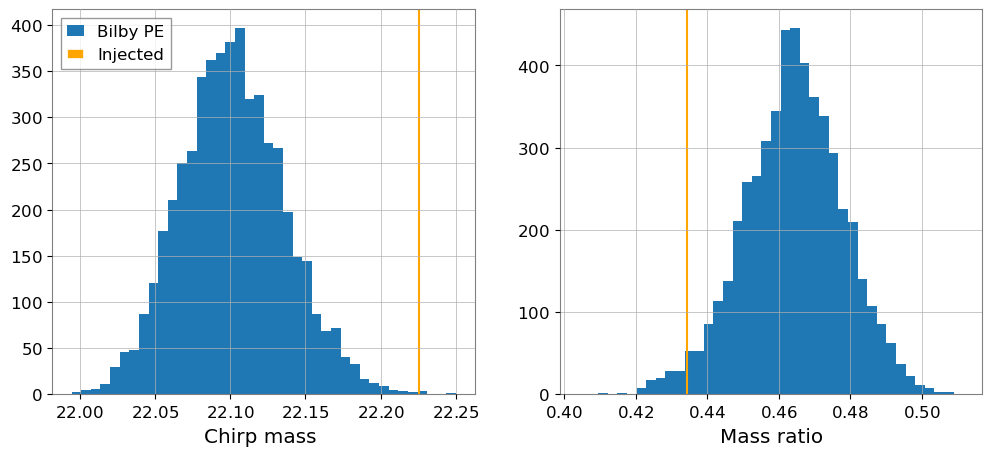

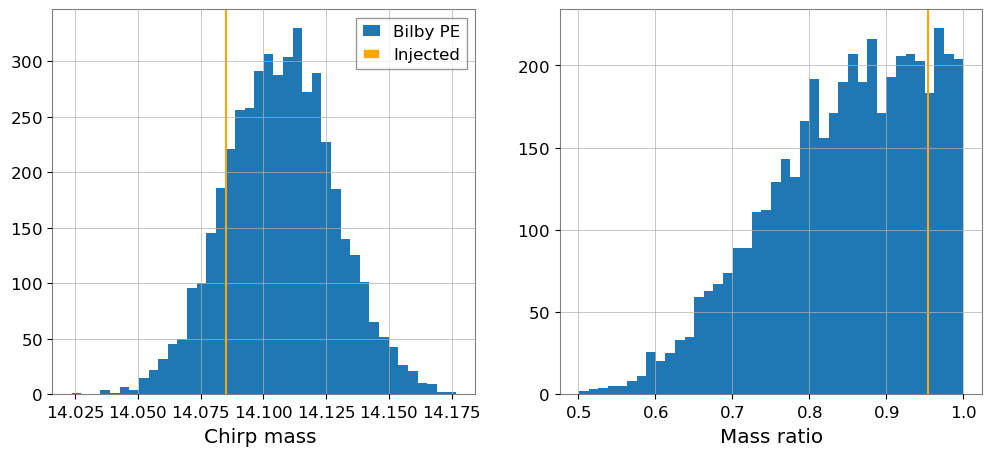

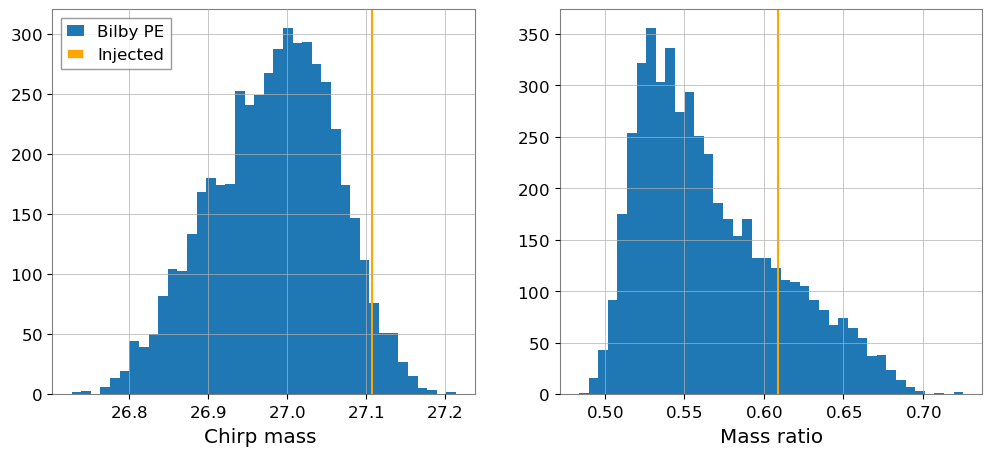

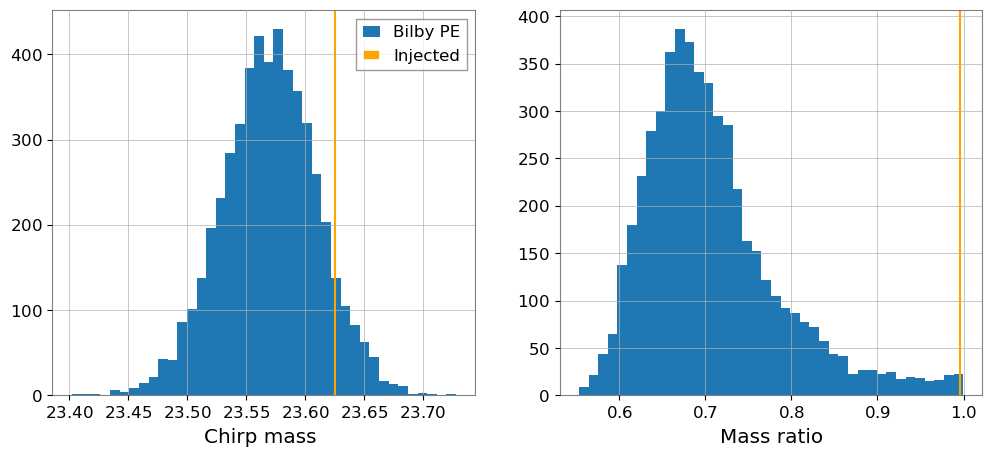

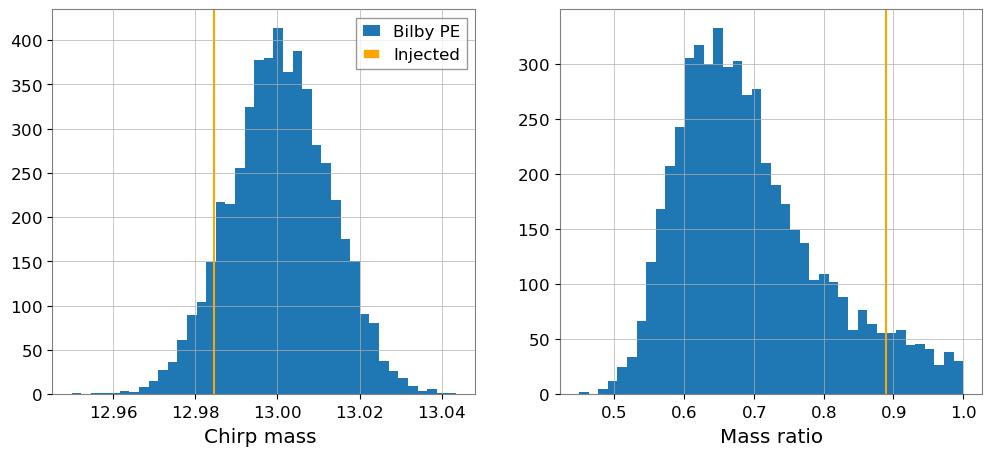

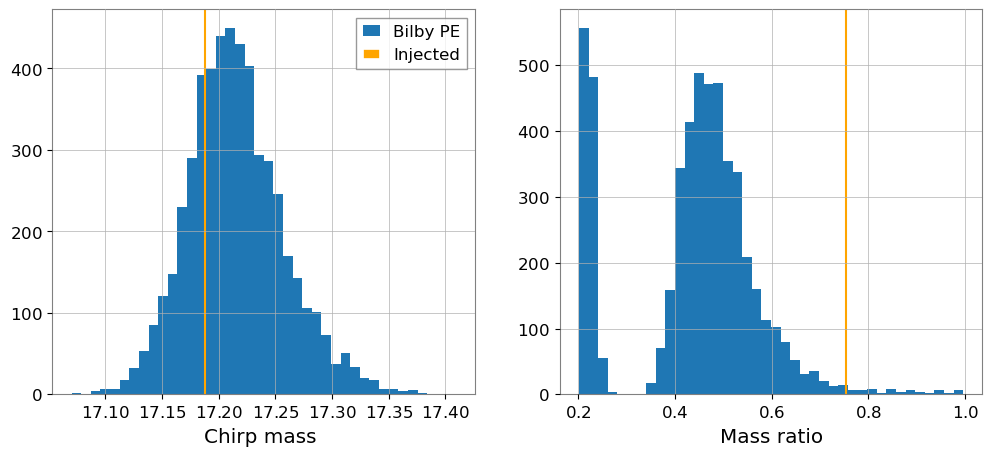

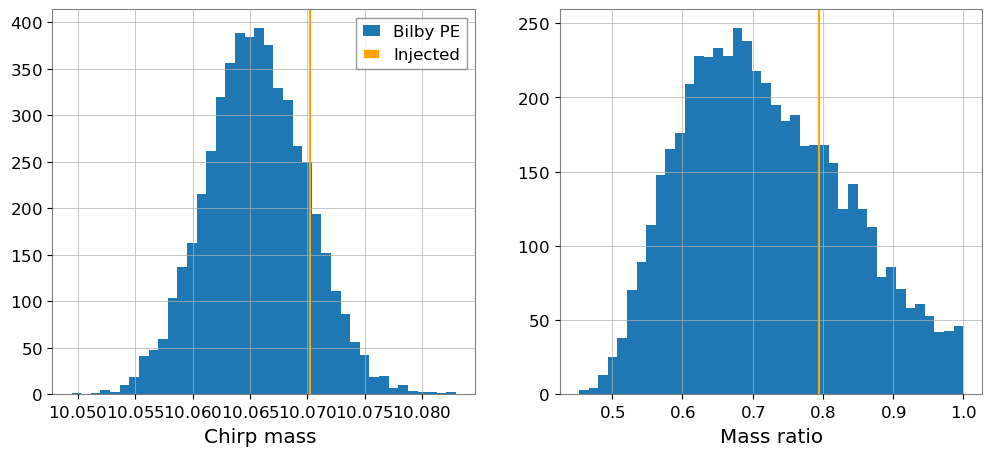

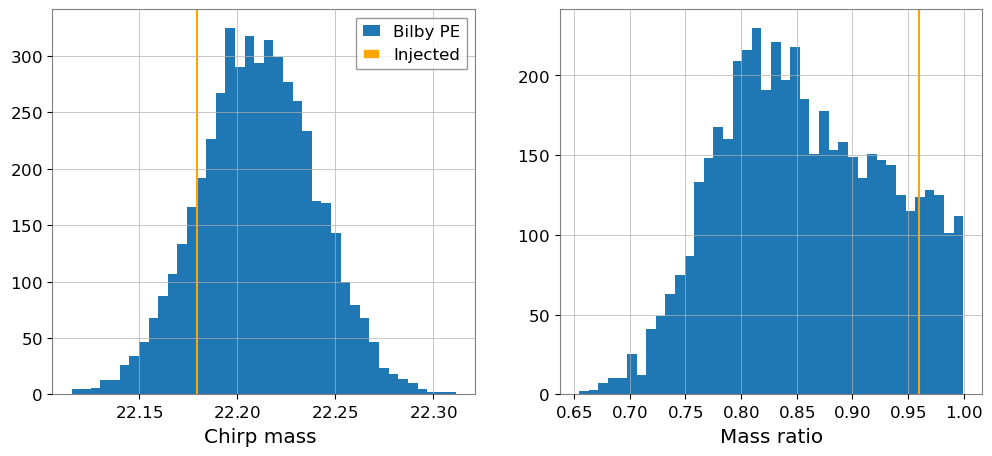

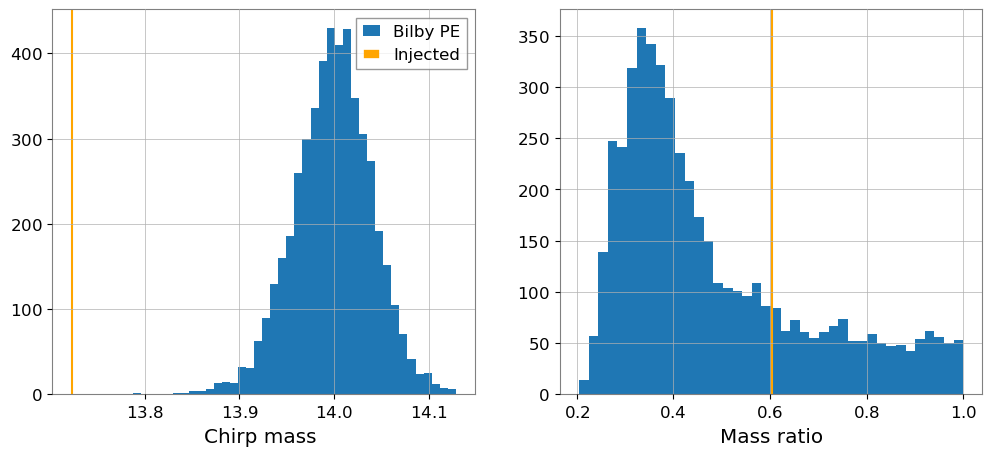

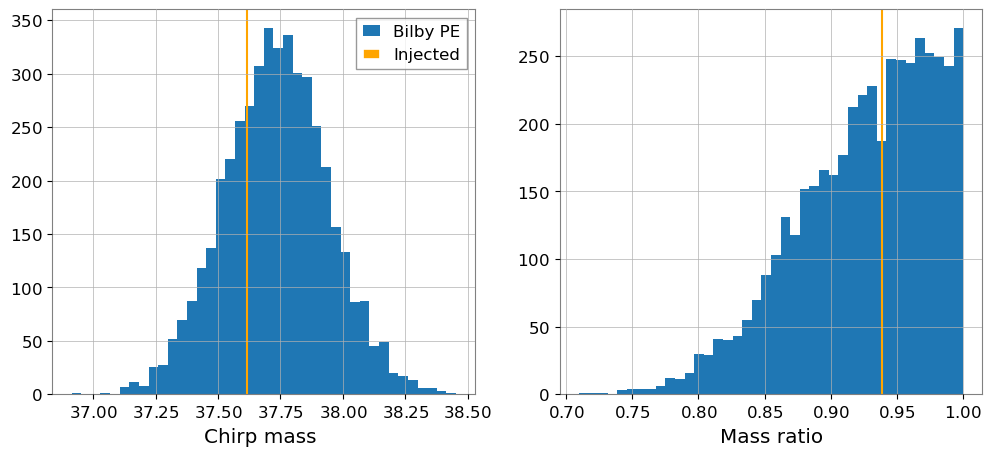

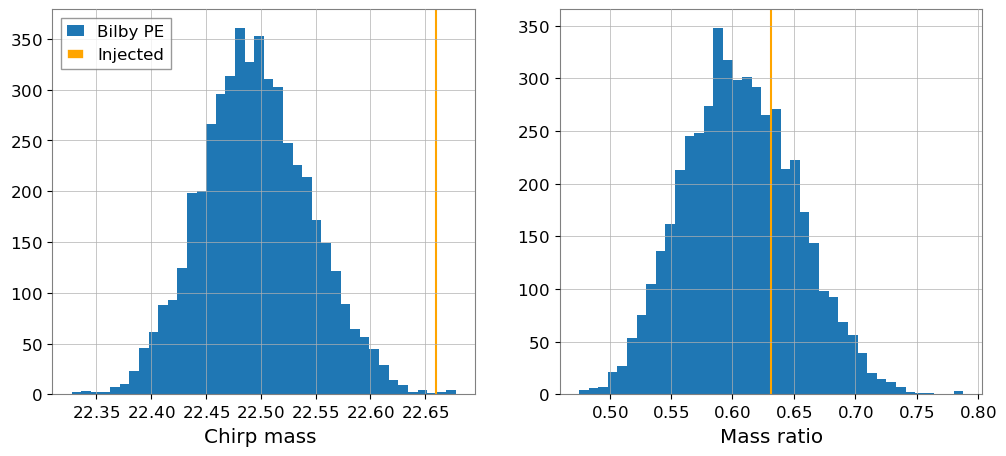

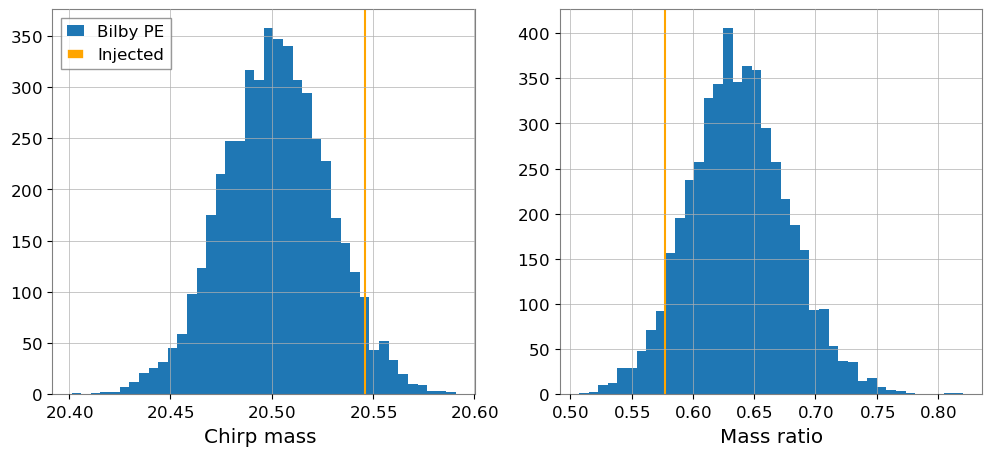

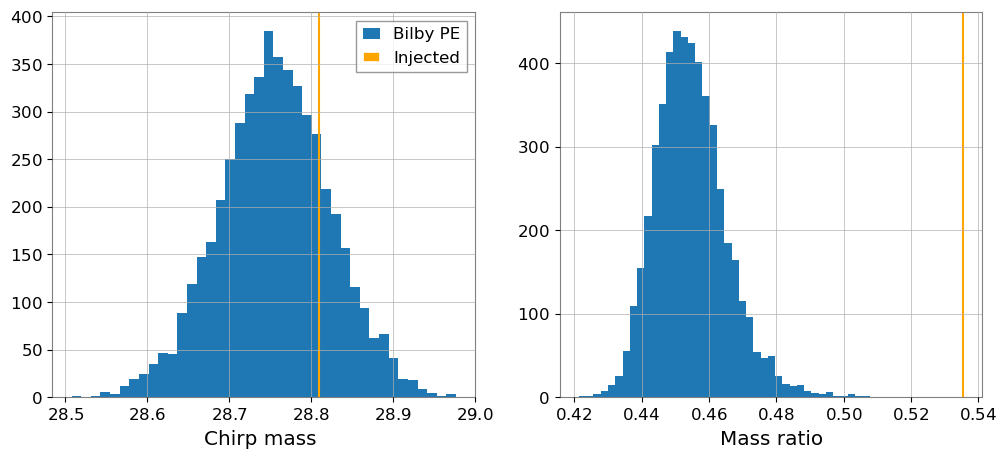

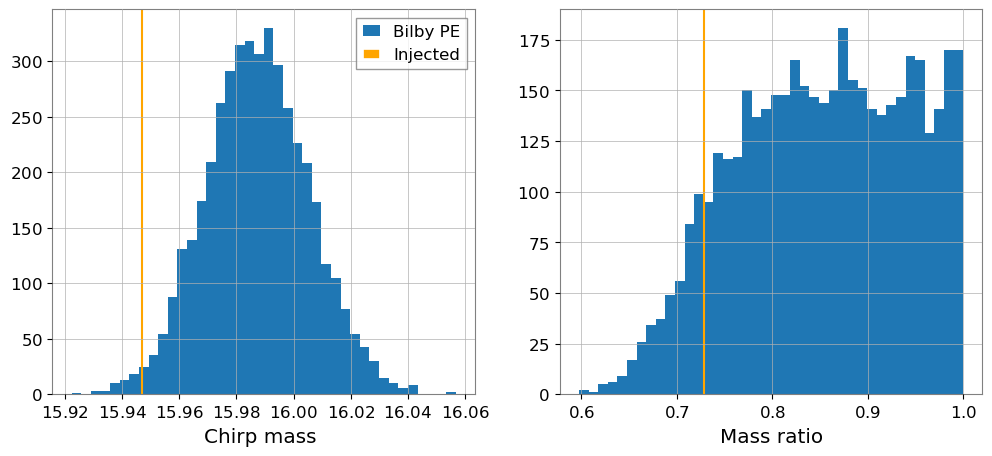

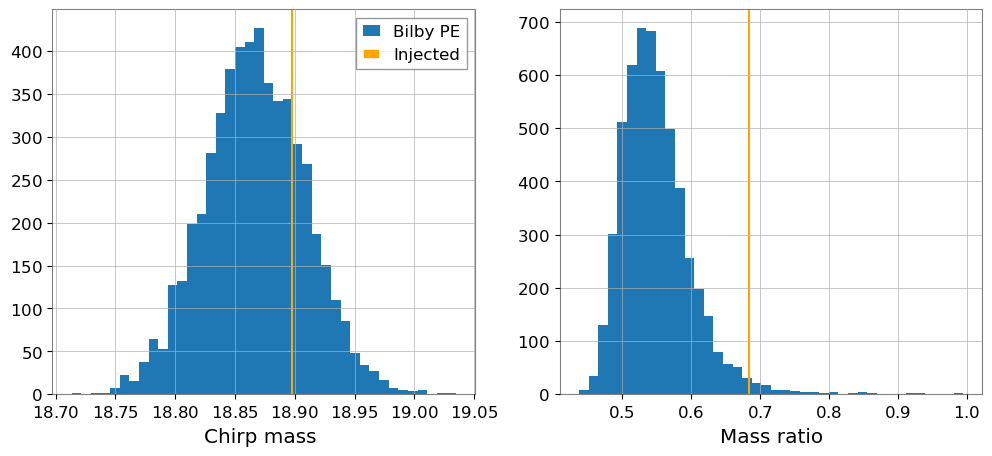

In [15]:

for pid in range(0, 20):
    try:
        trigtime = injection_times[pid]
        result_file = f"outdir_dc/virgo_deepclean_pe_injection_{pid}_result.json"
        results = bilby.result.read_in_result(result_file)
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.hist(results.posterior['chirp_mass'], 40, label="Bilby PE")
        plt.axvline(Mc_inj[pid], color = 'orange',  label = 'Injected')
        plt.xlabel("Chirp mass ")
        plt.legend()
        
        plt.subplot(122)
        plt.hist(results.posterior['mass_ratio'], 40, label="Bilby PE")
        plt.axvline(q_inj[pid], color = 'orange', label = 'Injected')
        plt.xlabel("Mass ratio")
    except:
        print(f"Results not available: {pid}")
        

Results not available: 21
Results not available: 23
Results not available: 25
Results not available: 26
Results not available: 34
Results not available: 36
Results not available: 39


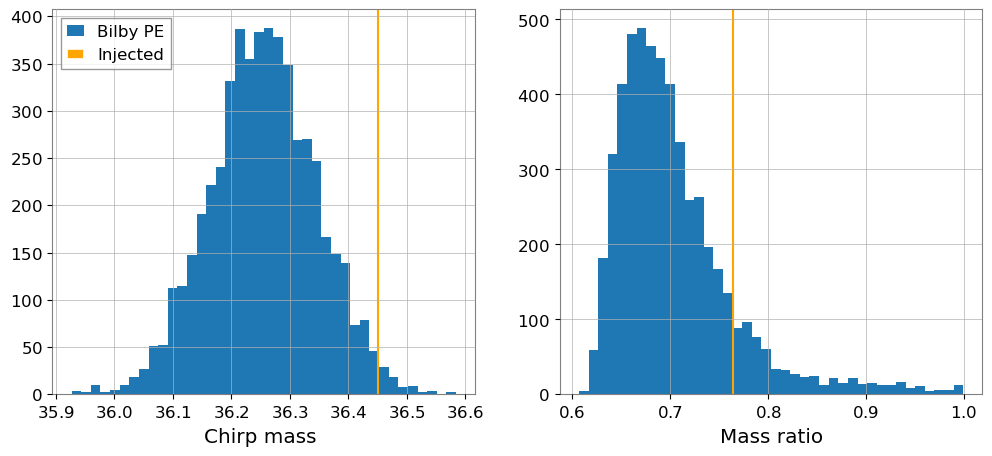

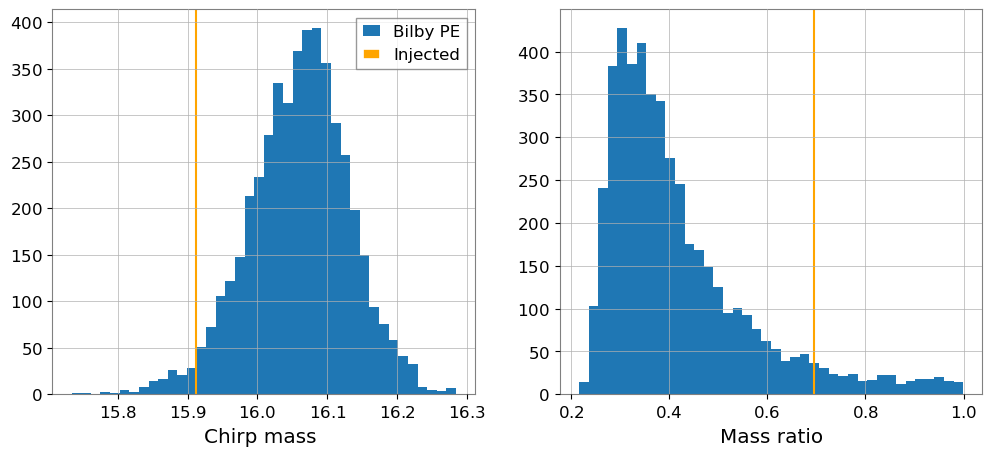

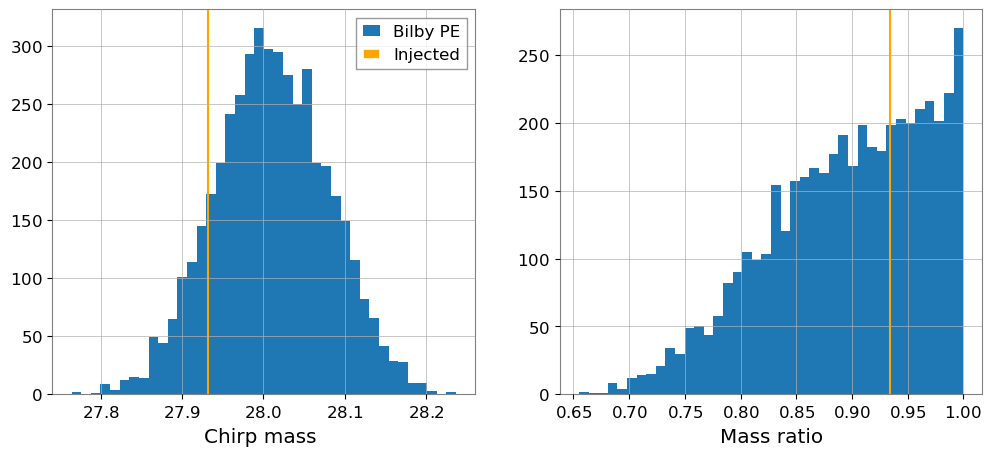

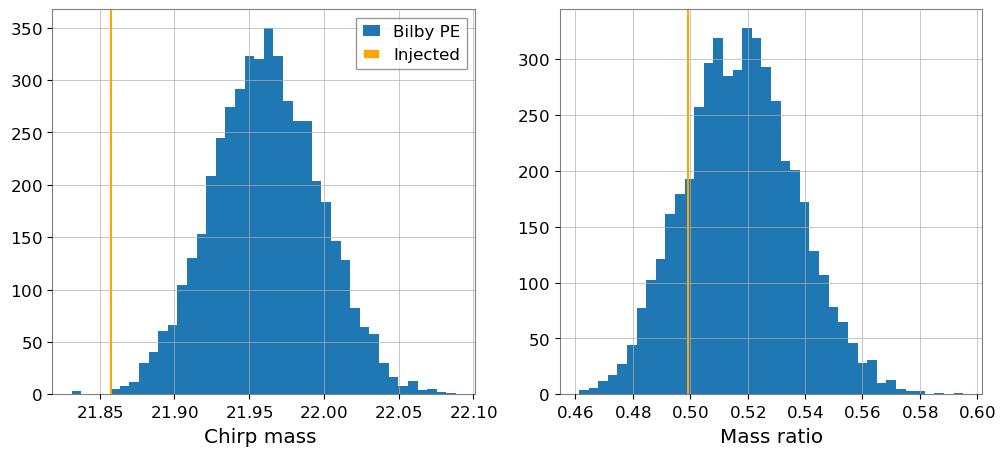

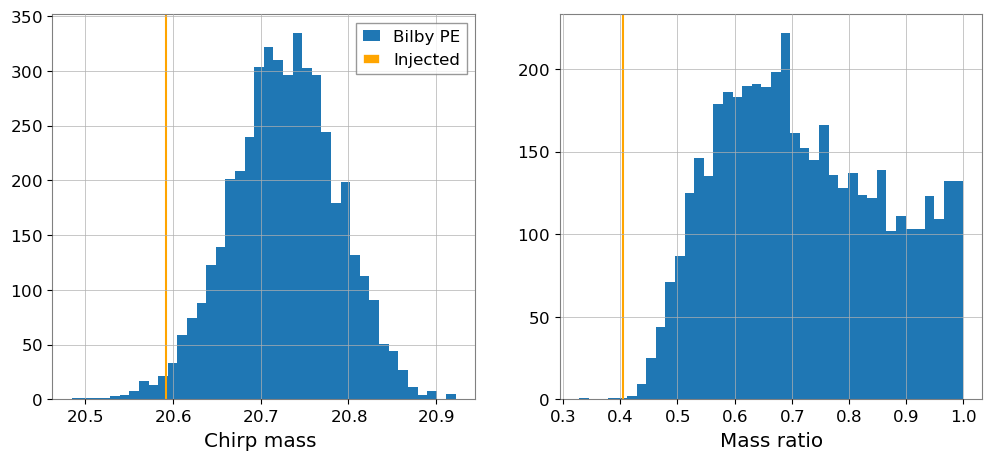

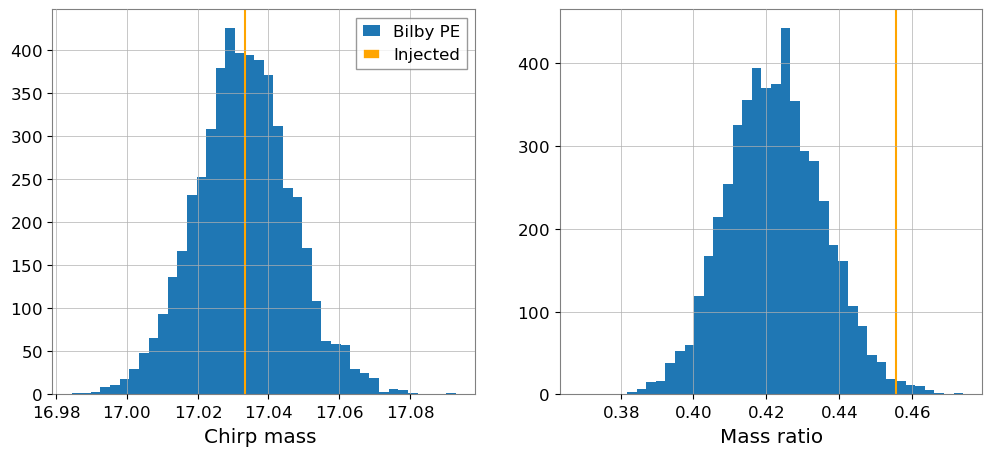

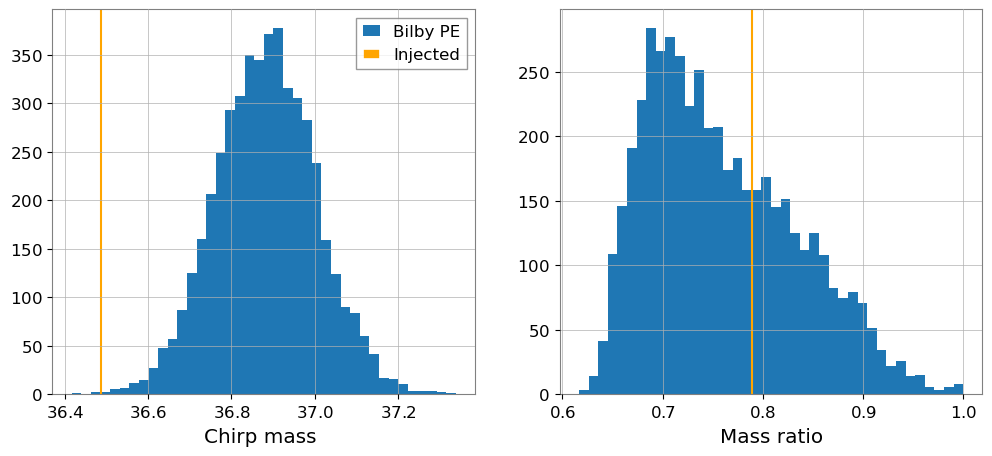

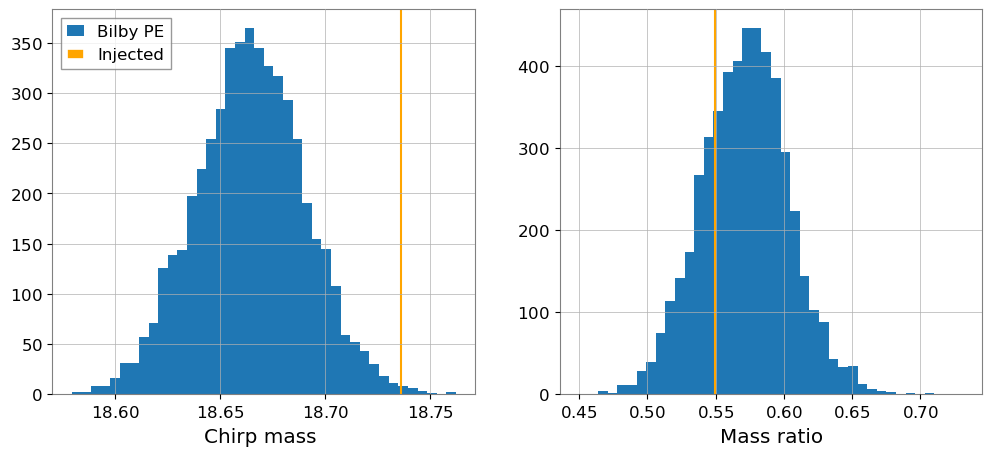

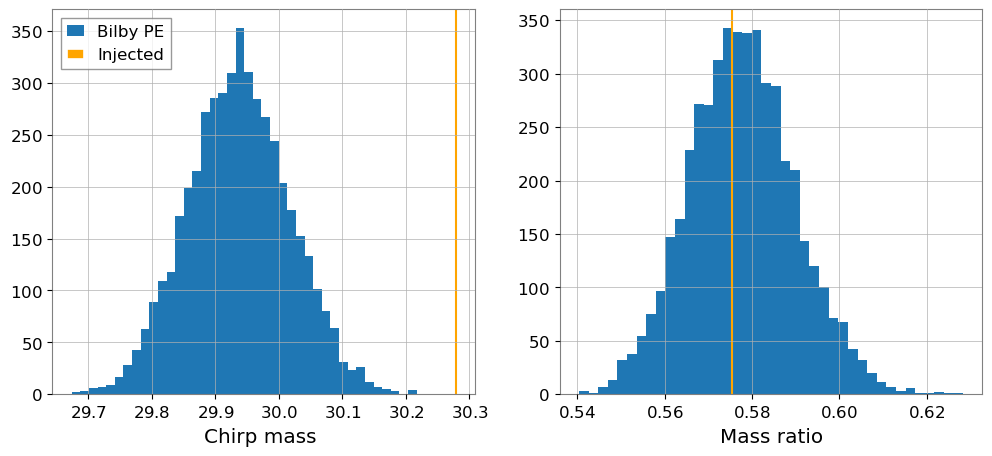

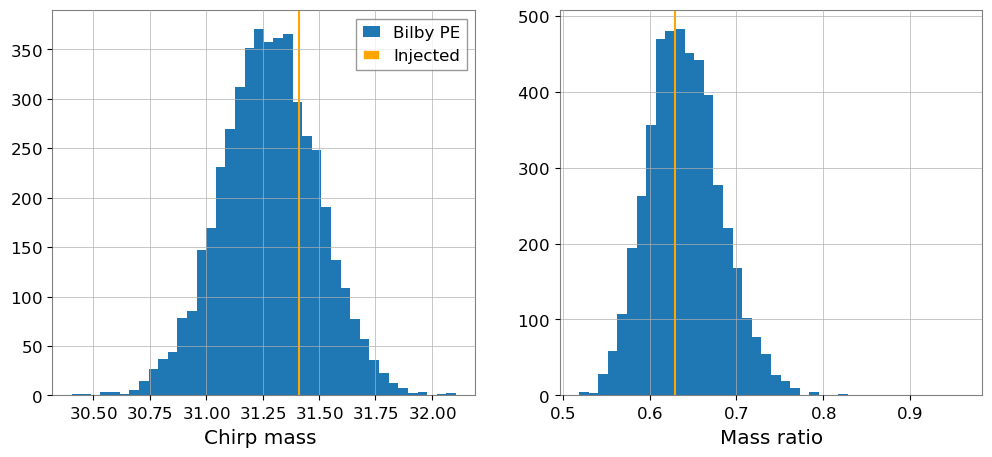

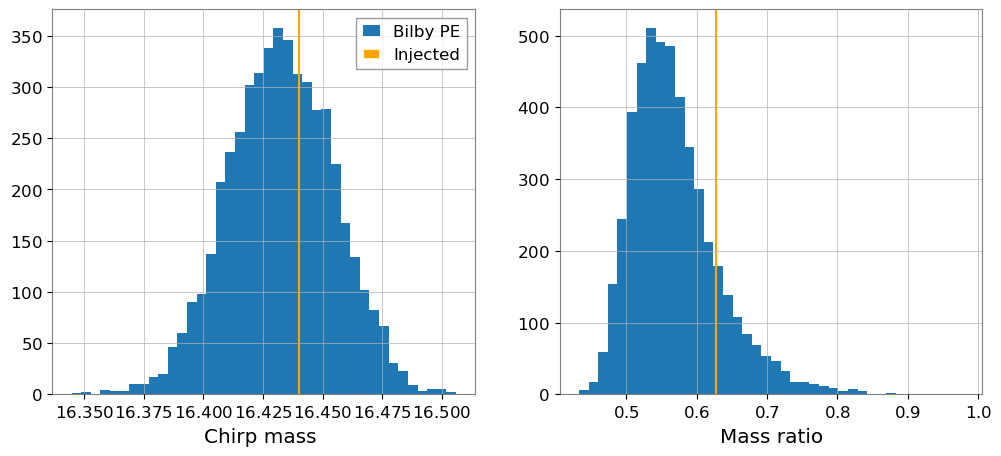

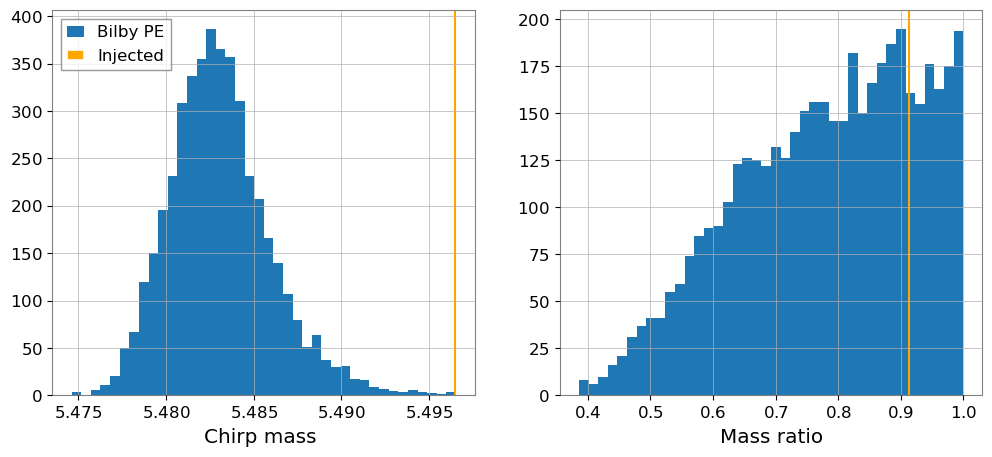

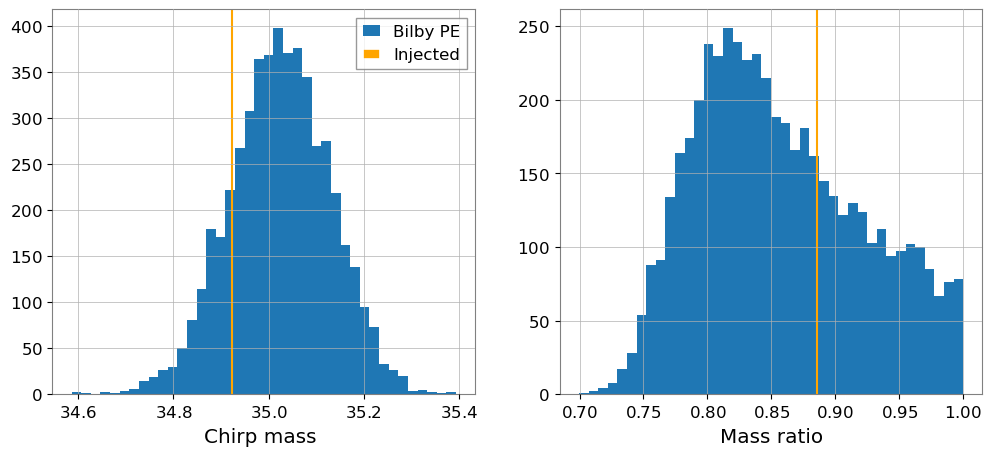

In [16]:
for pid in range(20, 40):
    try:
        trigtime = injection_times[pid]
        result_file = f"outdir_dc/virgo_deepclean_pe_injection_{pid}_result.json"
        results = bilby.result.read_in_result(result_file)
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.hist(results.posterior['chirp_mass'], 40, label="Bilby PE")
        plt.axvline(Mc_inj[pid], color = 'orange',  label = 'Injected')
        plt.xlabel("Chirp mass ")
        plt.legend()
        
        plt.subplot(122)
        plt.hist(results.posterior['mass_ratio'], 40, label="Bilby PE")
        plt.axvline(q_inj[pid], color = 'orange', label = 'Injected')
        plt.xlabel("Mass ratio")
    except:
        print(f"Results not available: {pid}")
        

Results not available: 43
Results not available: 45
Results not available: 46
Results not available: 48
Results not available: 54
Results not available: 59
Results not available: 60
Results not available: 61
Results not available: 65


/tmp/ipykernel_3839803/2554377328.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,5))


Results not available: 76


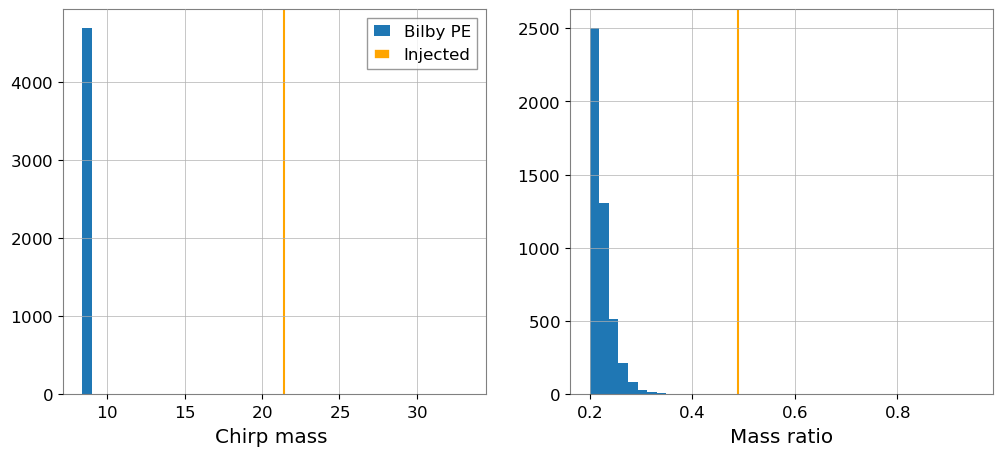

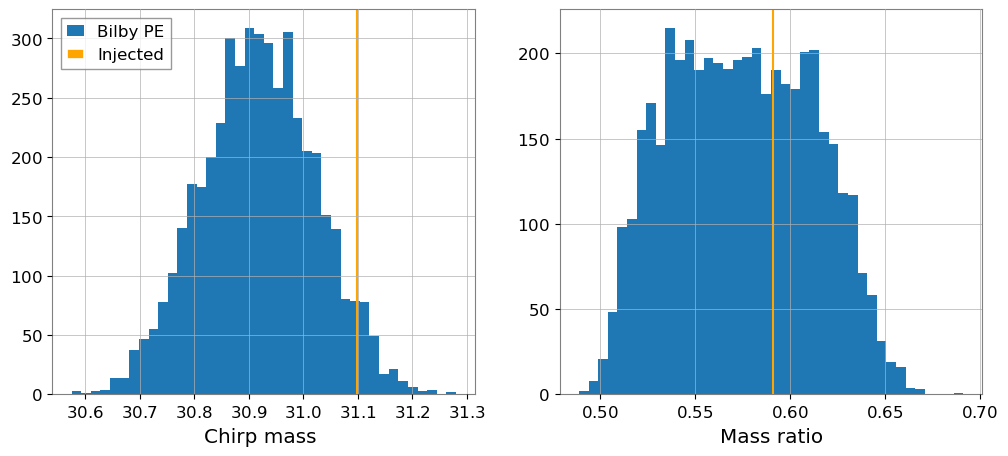

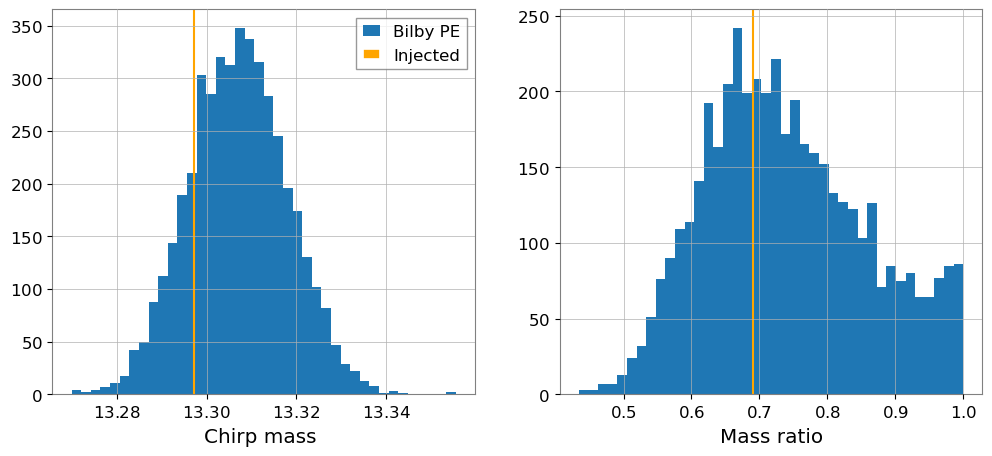

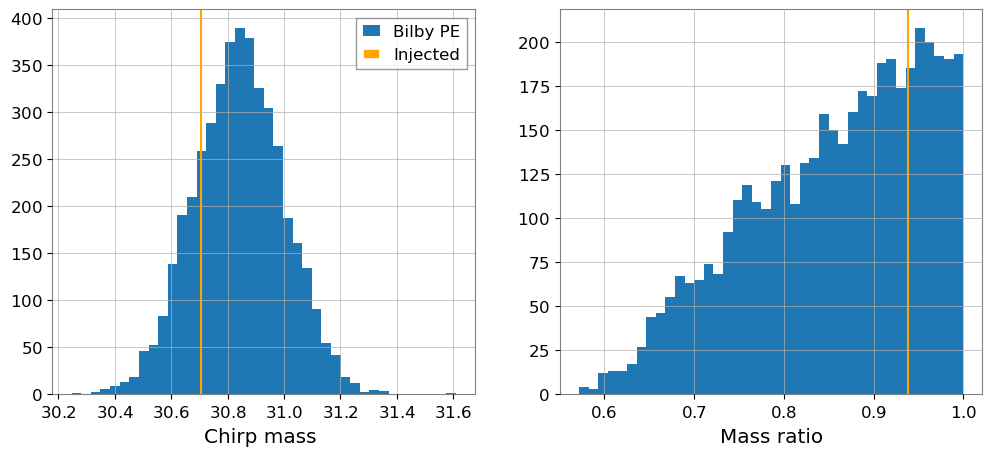

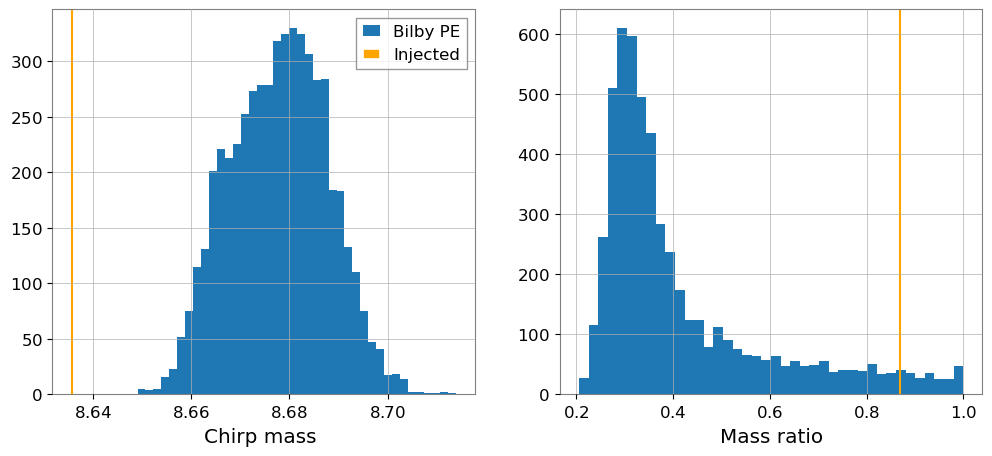

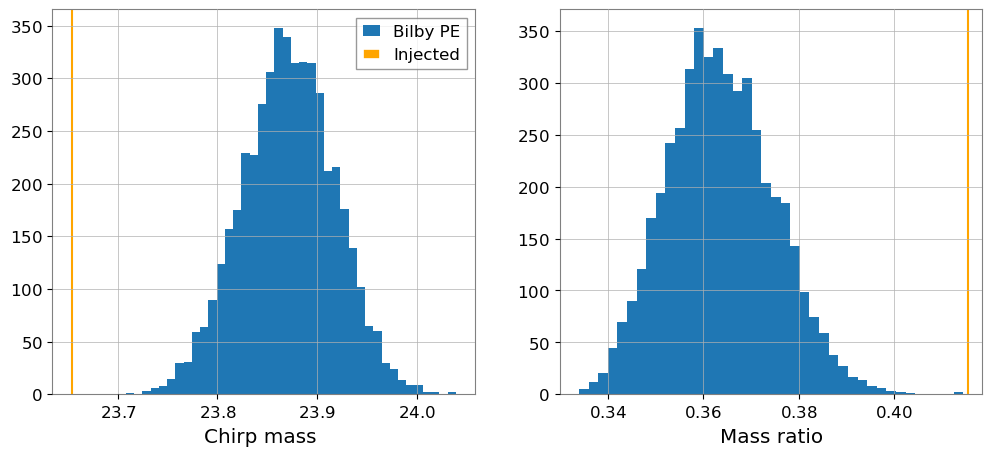

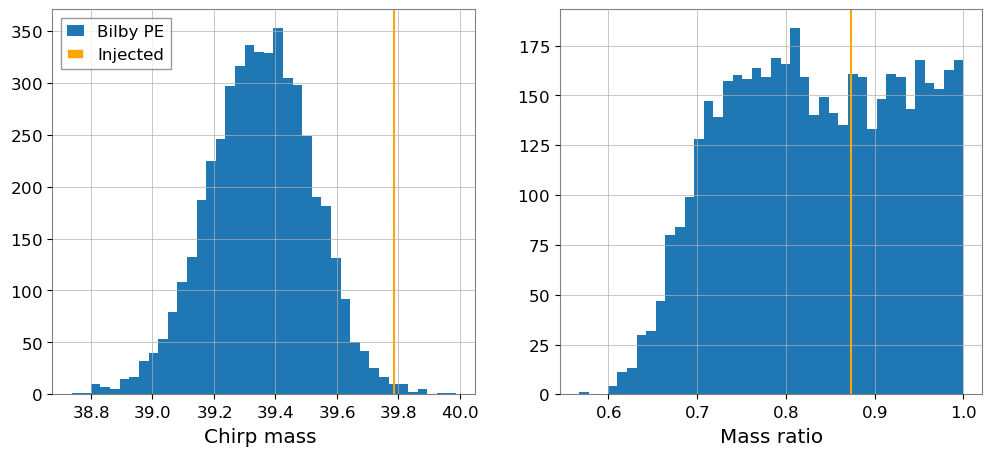

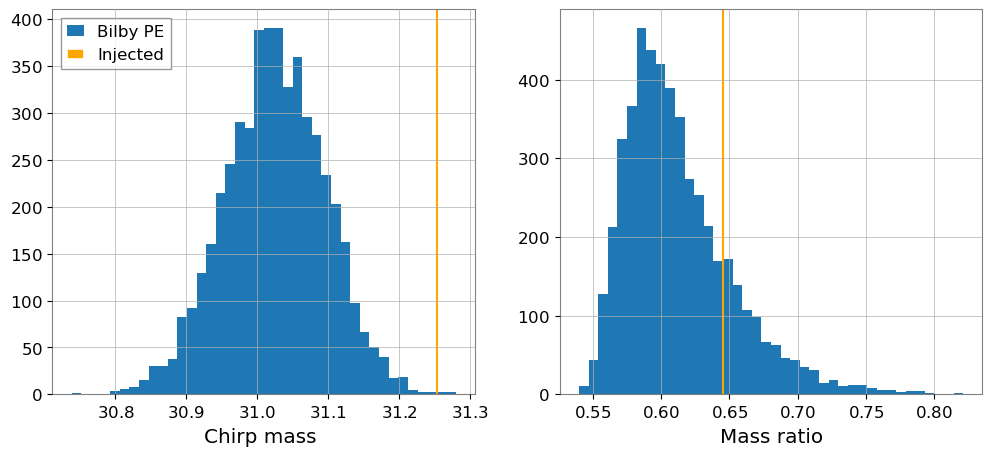

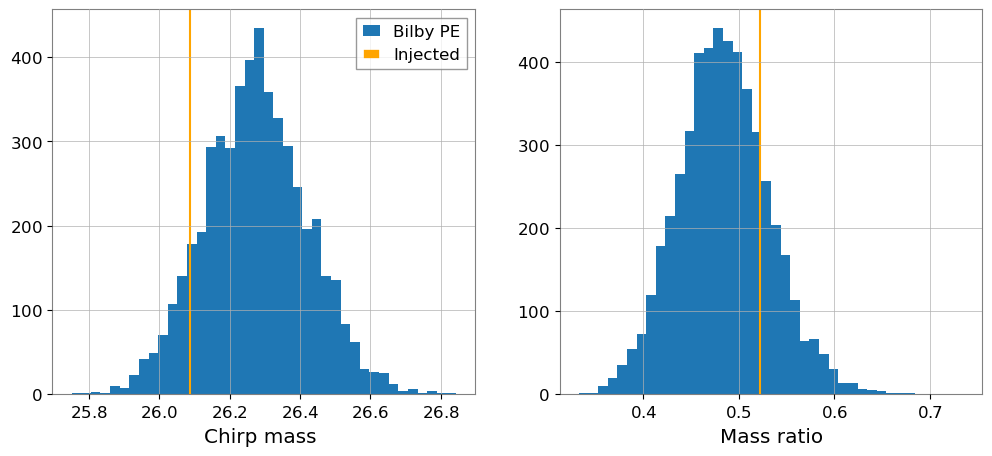

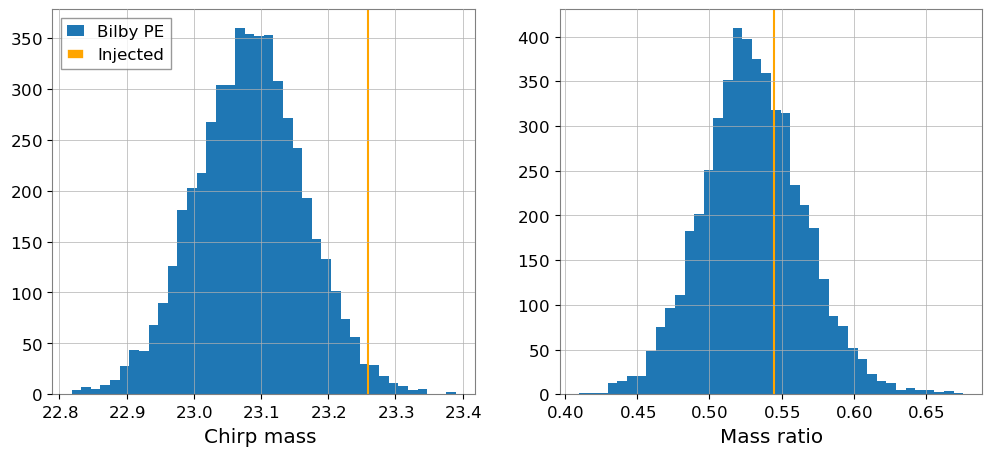

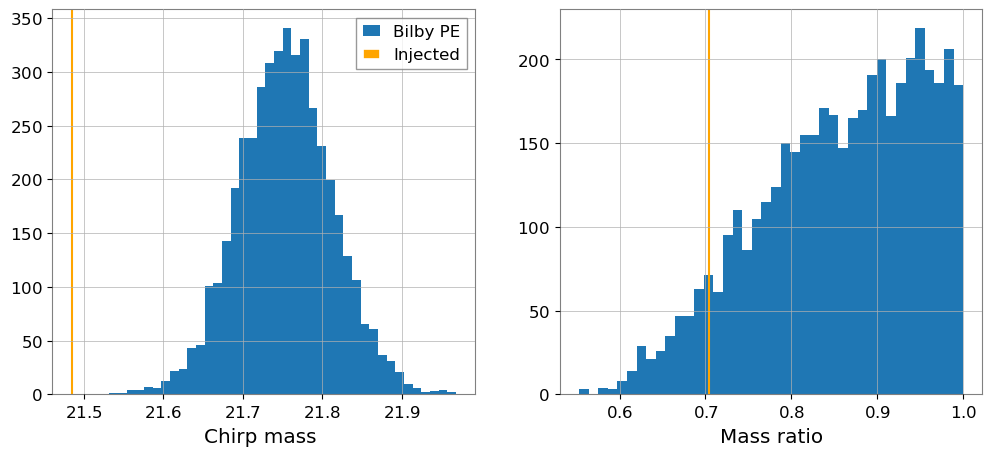

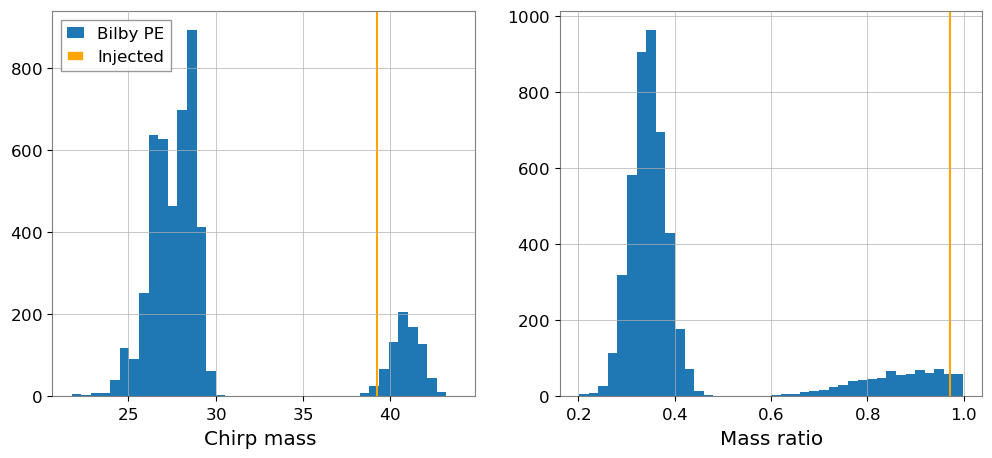

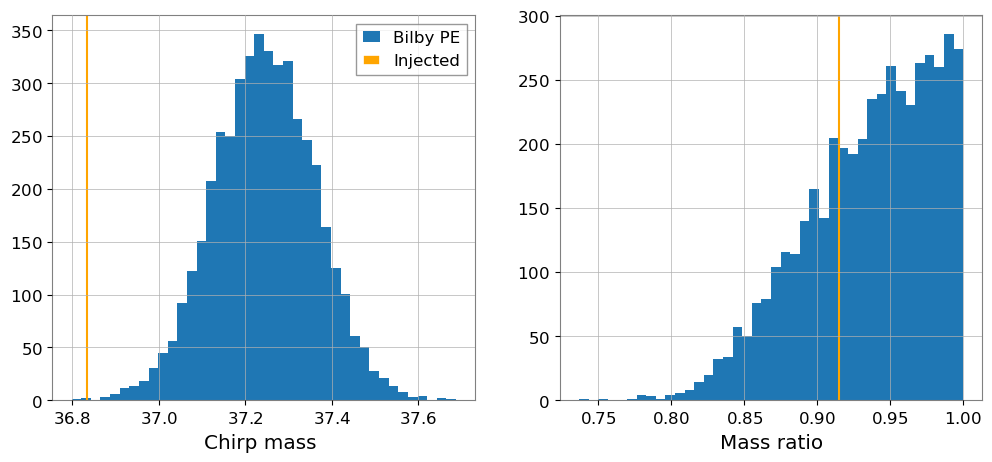

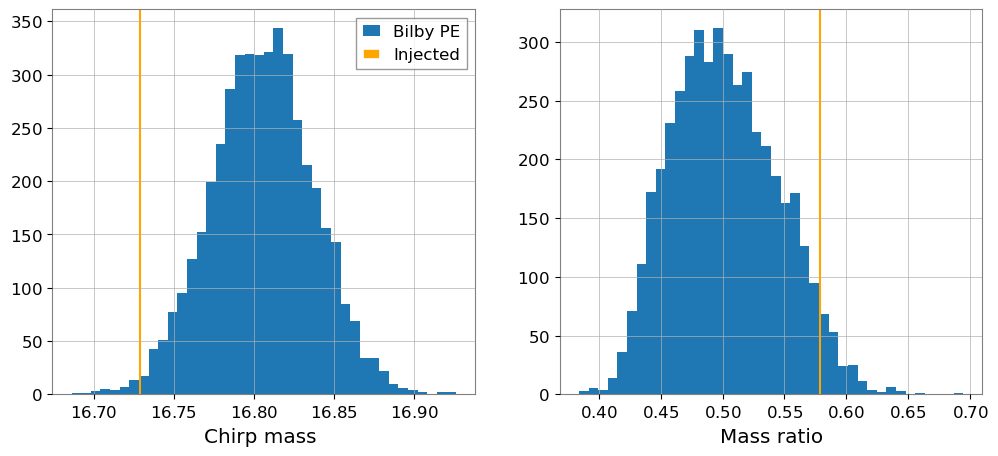

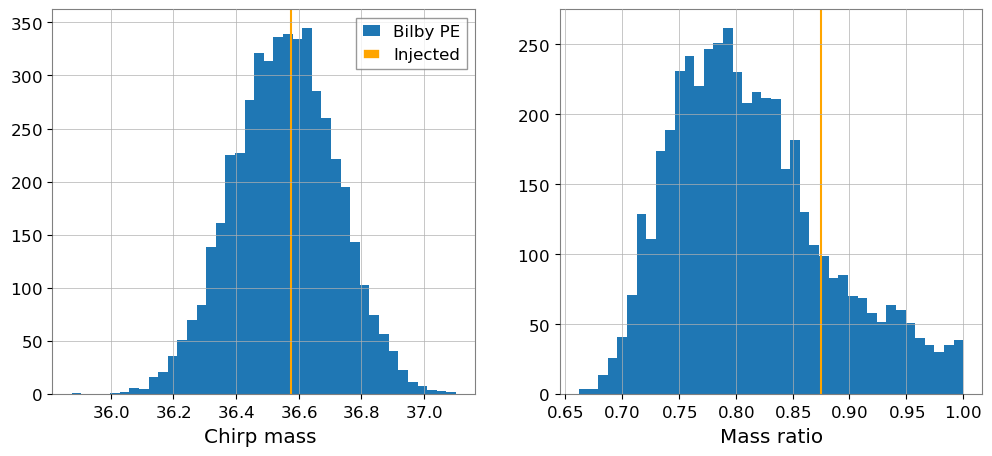

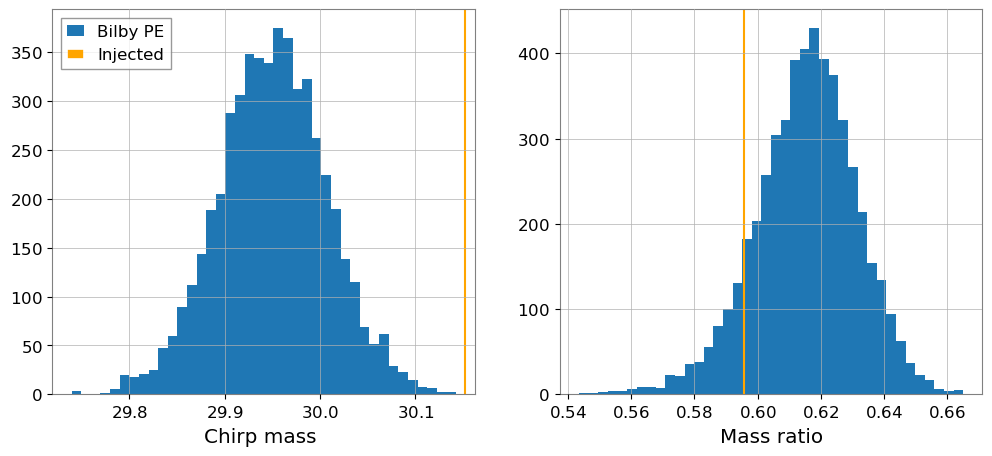

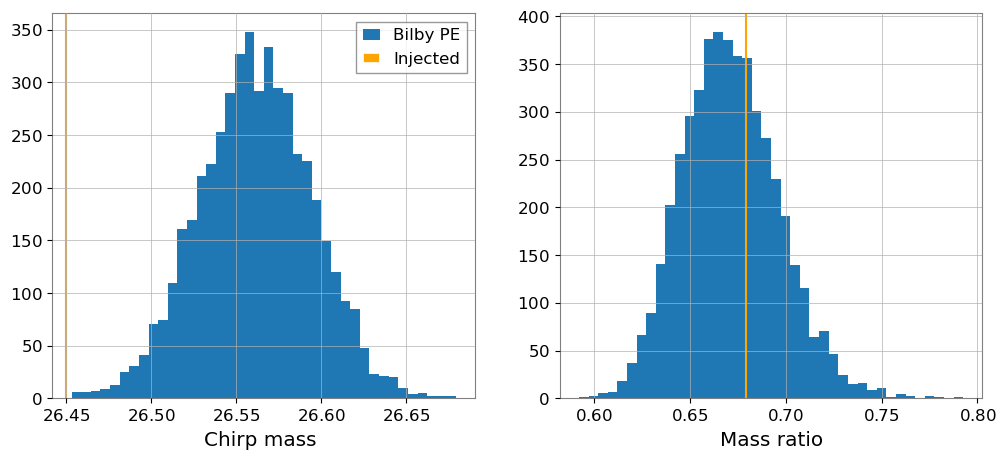

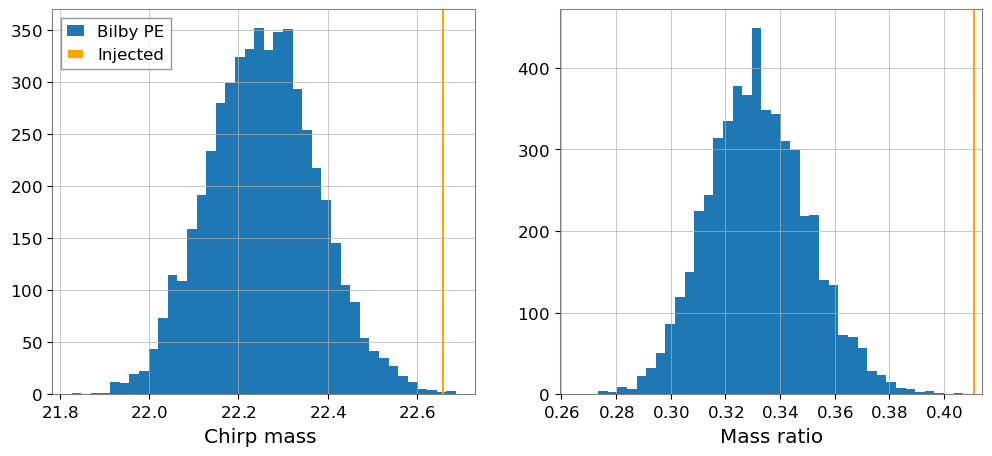

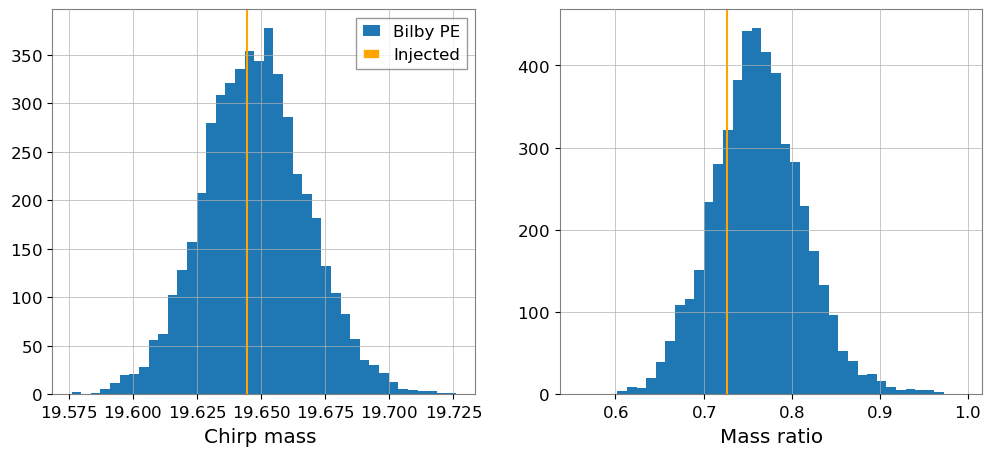

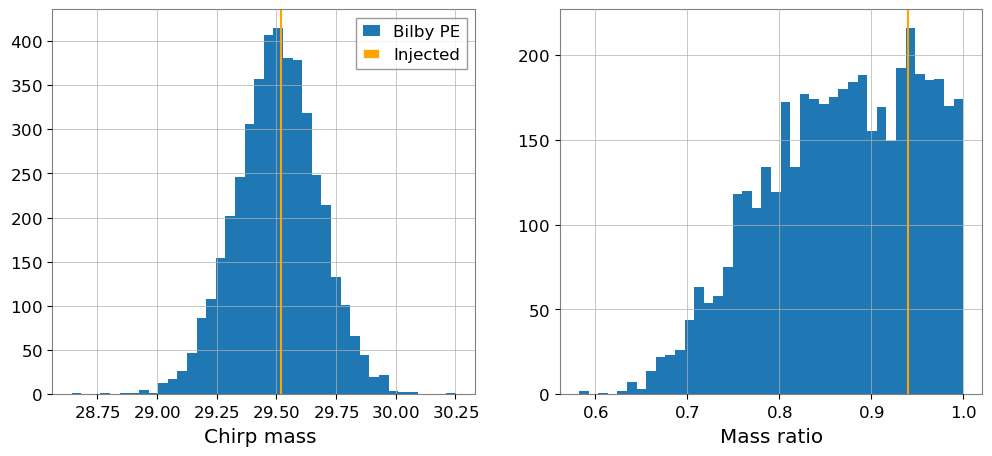

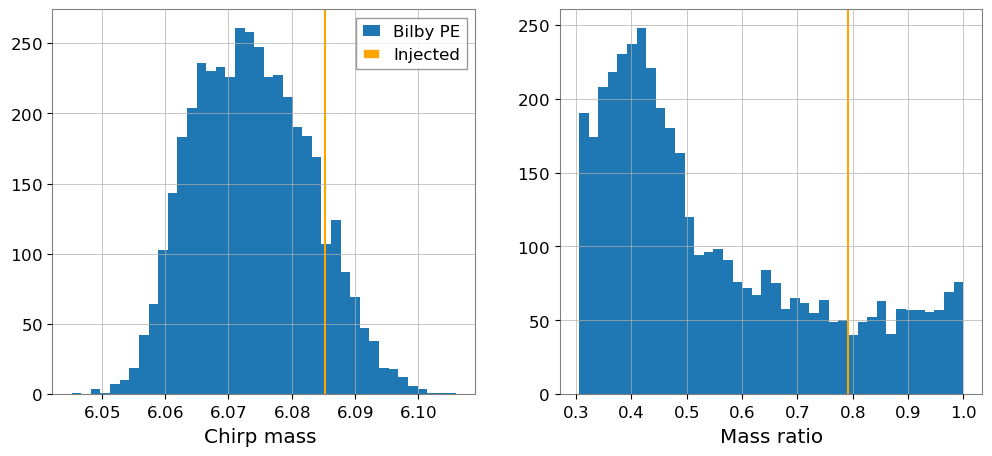

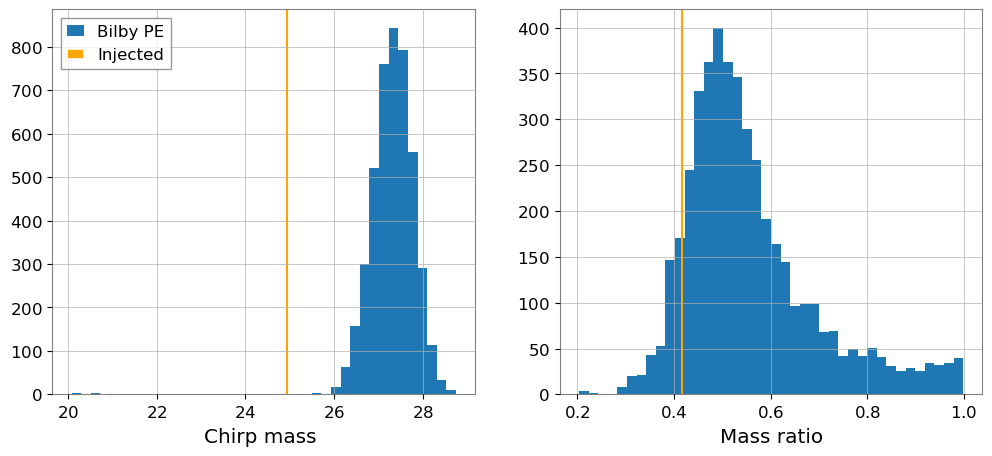

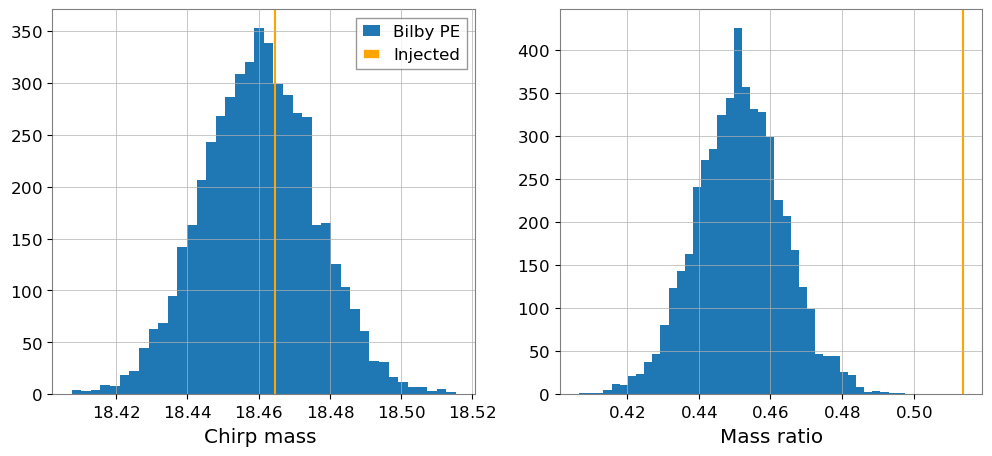

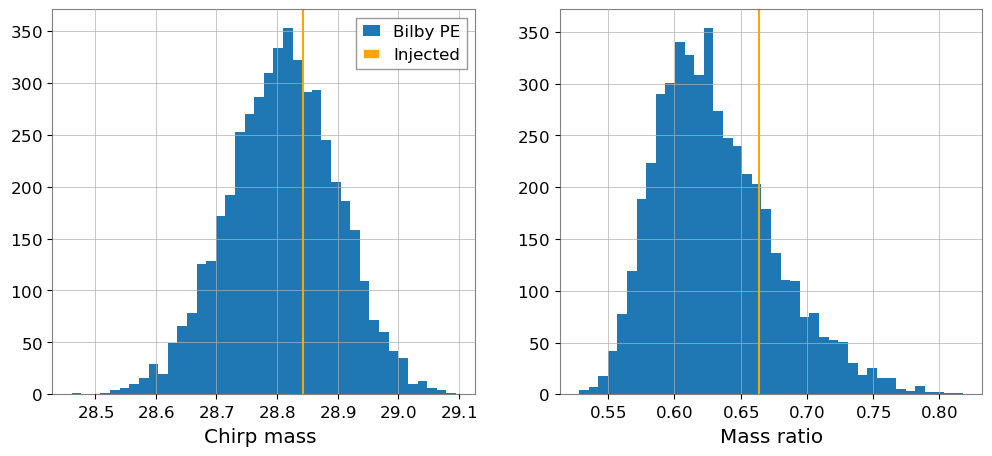

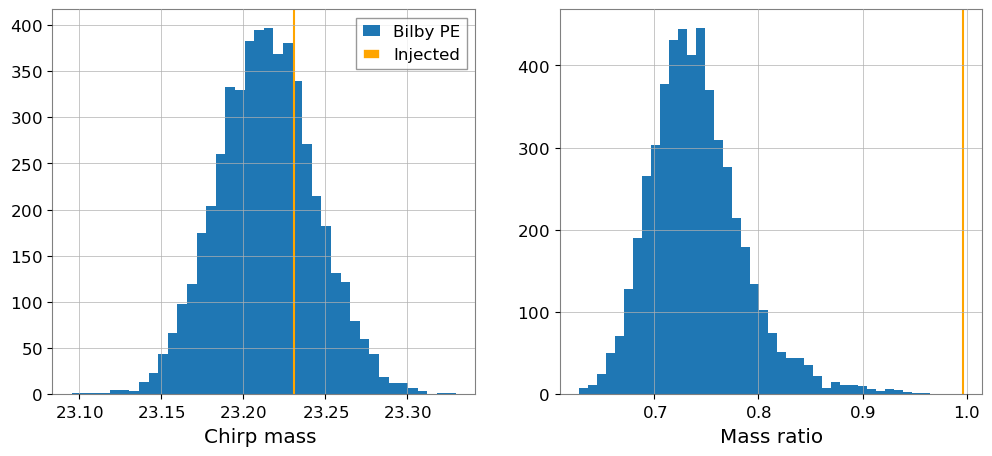

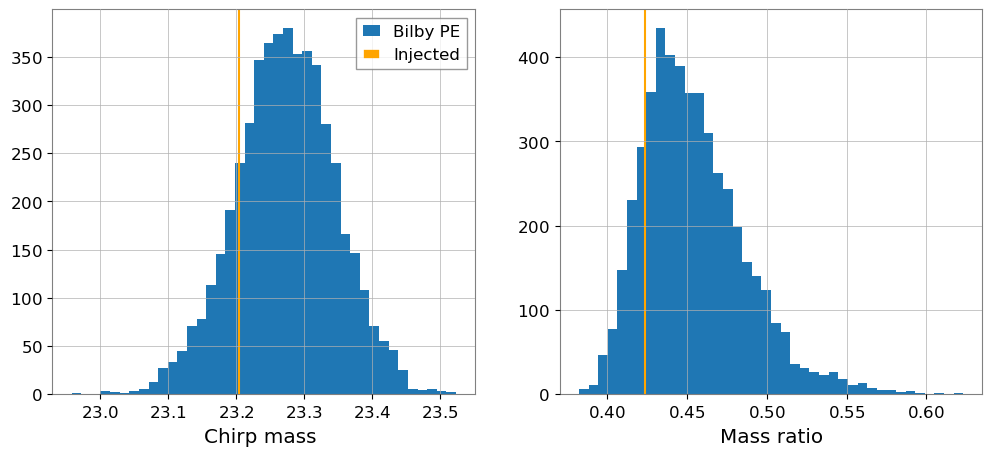

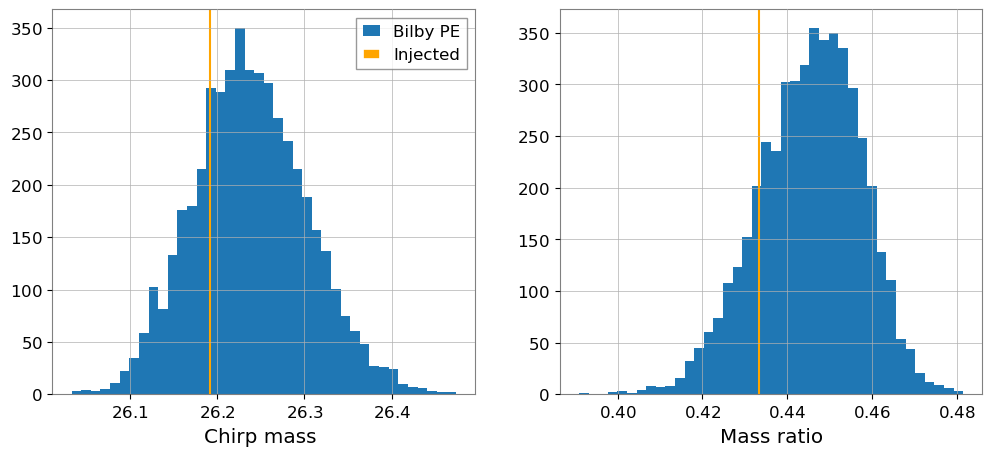

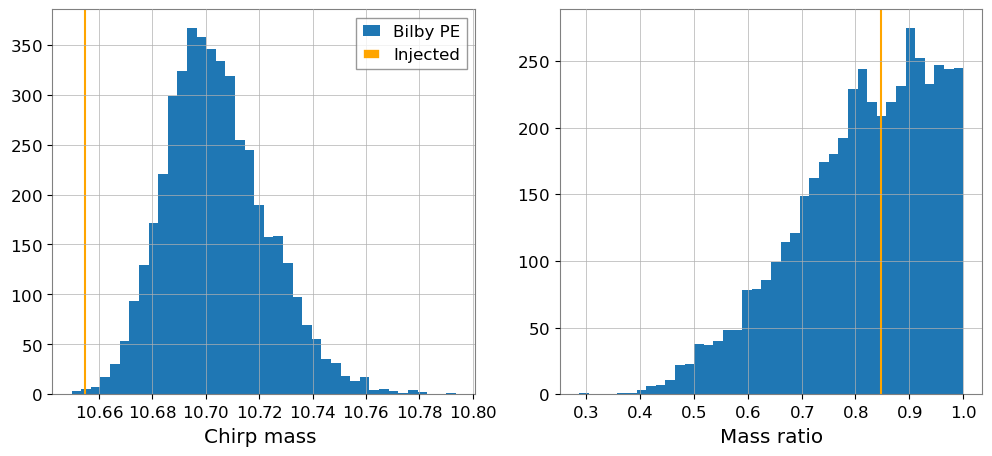

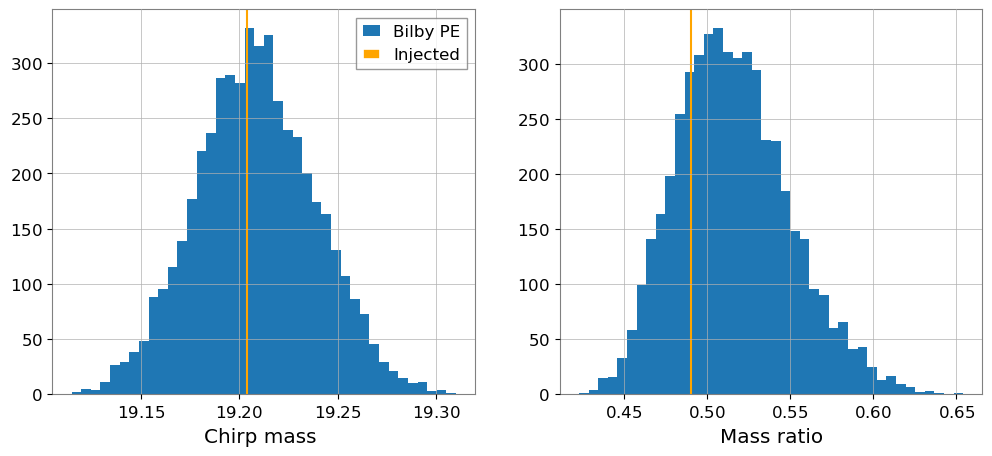

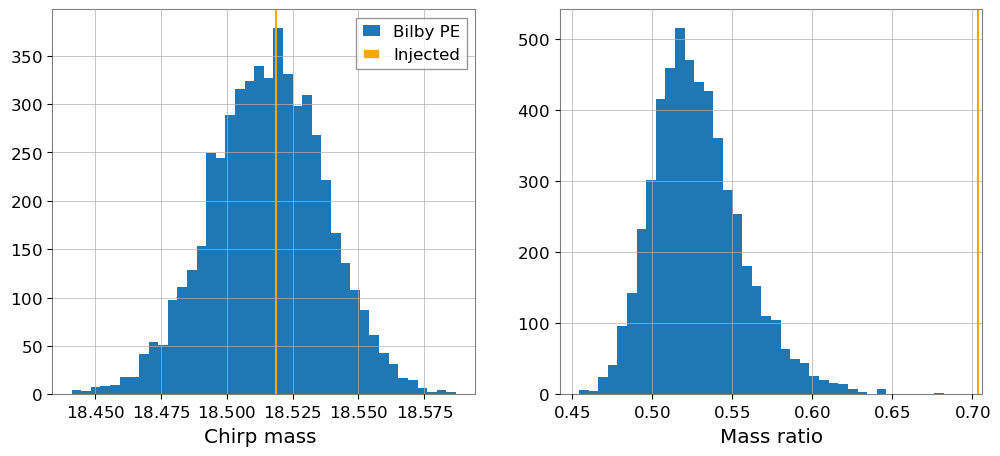

In [17]:
for pid in range(40, 80):
    try:
        trigtime = injection_times[pid]
        result_file = f"outdir_dc/virgo_deepclean_pe_injection_{pid}_result.json"
        results = bilby.result.read_in_result(result_file)
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.hist(results.posterior['chirp_mass'], 40, label="Bilby PE")
        plt.axvline(Mc_inj[pid], color = 'orange',  label = 'Injected')
        plt.xlabel("Chirp mass ")
        plt.legend()
        
        plt.subplot(122)
        plt.hist(results.posterior['mass_ratio'], 40, label="Bilby PE")
        plt.axvline(q_inj[pid], color = 'orange', label = 'Injected')
        plt.xlabel("Mass ratio")
    except:
        print(f"Results not available: {pid}")
        